## Title:  Predict 90-days mortality for MIMIC-III patients with Septicemia

### Problem Statement
* Septicemia is a life-threatening condition that requires early detection to reduce mortality rates. Traditional statistical models for predicting septicemia have limitations due to its multifactorial nature. The definition of sepsis has evolved over time to facilitate earlier recognition, but the latest version has been criticized for potentially leading to higher mortality rates. In this project, we aim to use the MIMIC-III dataset to build a deep learning model that predicts 90-day mortality for patients with septicemia.
    
    
    
* **Keywords:** Septicemia, early detection, multiple organ failures, mortality rates, traditional statistical models, deep learning models, comprehensive analysis, patient data, multifactorial, challenging task, definition, severity levels, severe sepsis, septic shock, bedside diagnosis, 2016 definition, higher mortality, MIMIC-III dataset, retrospective analysis, Medical Information Mart for Intensive Care, recorded between 2001 and 2012.
	

### Data Collection
* Source(url): https://physionet.org/content/mimiciii/1.4/
* Short Description : The MIMIC-III dataset is a vast and freely available database of electronic health records of patients admitted to Beth Israel Deaconess Medical Center. It contains data on over 40,000 patients admitted between 2001 and 2012, including clinical notes, laboratory test results, medications, and vital signs. The dataset is often used to study sepsis, a potentially life-threatening condition caused by the body's response to infection. By analyzing this data and building predictive models, researchers can identify factors that contribute to mortality in sepsis patients and develop more effective treatment strategies. The MIMIC-III dataset is a valuable resource for researchers and clinicians studying sepsis and other medical conditions.

* Keywords: Septicemia, early detection, multiple organ failures, mortality rates, traditional statistical models, deep learning models, comprehensive analysis, patient data, multifactorial, challenging task, definition, severity levels, severe sepsis, septic shock, bedside diagnosis, 2016 definition, higher mortality, MIMIC-III dataset, retrospective analysis, Medical Information Mart for Intensive Care, recorded between 2001 and 2012.

### Required packages

* Add instructions to install the required packages


In [ ]:
# import required libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import random
import keras
import matplotlib.pyplot as plt
import keras_tuner as kt
from sklearn.impute import SimpleImputer
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from scipy.stats.mstats import winsorize
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv1D, MaxPooling1D, Flatten, GRU, LSTM
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.layers import Concatenate
from sklearn.metrics import confusion_matrix,RocCurveDisplay,ConfusionMatrixDisplay

## Loading Data into Dataframes using Pandas
* Load data from local file into pandas dataframes*

In [ ]:
# patient information such as gender, date of birth, and date of death
patients = pd.read_csv('PATIENTS.csv')

# admission information such as admission and discharge dates, and admission type
admissions = pd.read_csv('ADMISSIONS.csv') 

# laboratory measurements for each patient
labevents = pd.read_csv('LABEVENTS.csv') 

# ICU stay information such as admission and discharge dates, and length of stay
icustays = pd.read_csv('ICUSTAYS.csv') 

# diagnoses codes for each patient admission
diagnoses = pd.read_csv('DIAGNOSES_ICD.csv') 

# information about each lab test, including the test name and normal ranges
d_labitems = pd.read_csv('D_LABITEMS.csv') 

In [ ]:
#List of ICD-9 codes associated with sepsis
sepsis_icd9 = ['31','202','223','380','382','383','388','389','545','3810','3811','3812',
               '3819','3841','3842','3843','3844','3849','65930','65931','65933','67020',
               '67022','67024','77181','78552','99591','99592']

## Analysis of the DIAGNOSES dataset from MIMIC-III Dataset

In [ ]:
#Display the shape and first 5 rows of the dataset
print(f"Shape of the diagnoses dataset is :{diagnoses.shape}")
diagnoses.head(5)

Shape of the diagnoses dataset is :(651047, 5)


ROW_ID  SUBJECT_ID  HADM_ID  SEQ_NUM ICD9_CODE
0    1297         109   172335      1.0     40301
1    1298         109   172335      2.0       486
2    1299         109   172335      3.0     58281
3    1300         109   172335      4.0      5855
4    1301         109   172335      5.0      4254

In [ ]:
#Drop the ROW_ID and SEQ_NUM columns from the dataset
diagnoses.drop(['ROW_ID','SEQ_NUM'],axis=1,inplace=True)

#Display information about the dataset
diagnoses.info()

#Filter the dataset to only include ICD9 codes related to sepsis
diagnoses = diagnoses[diagnoses['ICD9_CODE'].isin(sepsis_icd9)]

#Display the new shape and first 5 rows of the filtered dataset
print(f"Shape of the diagnoses dataset is :{diagnoses.shape}")
diagnoses.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651047 entries, 0 to 651046
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   SUBJECT_ID  651047 non-null  int64 
 1   HADM_ID     651047 non-null  int64 
 2   ICD9_CODE   651000 non-null  object
dtypes: int64(2), object(1)
memory usage: 14.9+ MB
Shape of the diagnoses dataset is :(7995, 3)


SUBJECT_ID  HADM_ID ICD9_CODE
87          117   164853     99592
144         124   138376     99592
276          64   172056     99591
450          85   112077     99591
497          92   142807     77181

In the above Dataframe, We have three features, let us discuss about them : 

SUBJECT_ID: A unique identifier assigned to each patient in a hospital dataset.

HADM_ID: A unique identifier assigned to each hospital admission in a hospital dataset.

ICD9_CODE: A code used to represent medical diagnoses and procedures in hospital datasets, based on the International Classification of Diseases, Ninth Revision (ICD-9) system.

## Analysis of the PATIENTS dataset from MIMIC-III Dataset

In [ ]:
#Display the shape and first 5 rows of the dataset
print(f"Shape of the patients dataset is :{patients.shape}")
patients.head(5)

Shape of the patients dataset is :(46520, 8)


ROW_ID  SUBJECT_ID GENDER                  DOB                  DOD  \
0     234         249      F  2075-03-13 00:00:00                  NaN   
1     235         250      F  2164-12-27 00:00:00  2188-11-22 00:00:00   
2     236         251      M  2090-03-15 00:00:00                  NaN   
3     237         252      M  2078-03-06 00:00:00                  NaN   
4     238         253      F  2089-11-26 00:00:00                  NaN   

              DOD_HOSP DOD_SSN  EXPIRE_FLAG  
0                  NaN     NaN            0  
1  2188-11-22 00:00:00     NaN            1  
2                  NaN     NaN            0  
3                  NaN     NaN            0  
4                  NaN     NaN            0

In [ ]:
#Print information about the dataset
patients.info()

#Drop unnecessary columns from the dataset
patients.drop(['ROW_ID','DOD','DOD_HOSP','DOD_SSN','EXPIRE_FLAG'],axis=1,inplace=True)

#Display the new shape and first 5 rows of the dataset
print("Shape of the patients data is : ",patients.shape)
patients.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46520 entries, 0 to 46519
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ROW_ID       46520 non-null  int64 
 1   SUBJECT_ID   46520 non-null  int64 
 2   GENDER       46520 non-null  object
 3   DOB          46520 non-null  object
 4   DOD          15759 non-null  object
 5   DOD_HOSP     9974 non-null   object
 6   DOD_SSN      13378 non-null  object
 7   EXPIRE_FLAG  46520 non-null  int64 
dtypes: int64(3), object(5)
memory usage: 2.8+ MB
Shape of the patients data is :  (46520, 3)


SUBJECT_ID GENDER                  DOB
0         249      F  2075-03-13 00:00:00
1         250      F  2164-12-27 00:00:00
2         251      M  2090-03-15 00:00:00
3         252      M  2078-03-06 00:00:00
4         253      F  2089-11-26 00:00:00

In the above Dataframe, We have three features, let us discuss about them :

SUBJECT_ID: A unique identifier assigned to each patient in a hospital dataset.

GENDER: The biological sex of the patient, typically recorded as either male or female in hospital datasets.

DOB: The date of birth of the patient, recorded in a standardized format such as YYYY-MM-DD in hospital datasets.

In the above dataframe, we can observe that there are missing / null values in it in the date of death, date of death in hospital and date of death of patient in the Social security record. Null values in these are common and they mean person is still alive. So, No problem for the analysis, Since we have the same data in other tables we are dropping them now!

##  Merging of Diagnoses and Patients dataframes on 'SUBJECT_ID'

In [ ]:
patietns_diagnoses = pd.merge(diagnoses,patients,how='inner',on=['SUBJECT_ID'])

Using, the above command we can merge the both dataframes into one, which is one of the preliminary step in getting the final dataframe.

## Analysis of the ADMISSIONS dataset from MIMIC-III Dataset

In [ ]:
# Print information about the admissions dataset
admissions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ROW_ID                58976 non-null  int64 
 1   SUBJECT_ID            58976 non-null  int64 
 2   HADM_ID               58976 non-null  int64 
 3   ADMITTIME             58976 non-null  object
 4   DISCHTIME             58976 non-null  object
 5   DEATHTIME             5854 non-null   object
 6   ADMISSION_TYPE        58976 non-null  object
 7   ADMISSION_LOCATION    58976 non-null  object
 8   DISCHARGE_LOCATION    58976 non-null  object
 9   INSURANCE             58976 non-null  object
 10  LANGUAGE              33644 non-null  object
 11  RELIGION              58518 non-null  object
 12  MARITAL_STATUS        48848 non-null  object
 13  ETHNICITY             58976 non-null  object
 14  EDREGTIME             30877 non-null  object
 15  EDOUTTIME             30877 non-null

In [ ]:
# Define a list of columns to drop from the admissions dataset which are unrelevant to analysis
cols = ['ROW_ID','DISCHTIME','EDREGTIME','EDOUTTIME','ADMISSION_LOCATION','INSURANCE',
        'DISCHARGE_LOCATION','LANGUAGE','RELIGION','MARITAL_STATUS','ETHNICITY',
        'HOSPITAL_EXPIRE_FLAG','HAS_CHARTEVENTS_DATA']

# Drop the specified columns from the admissions dataset
admissions.drop(cols,axis=1,inplace=True)

# Print the shape of the resulting admissions dataset and the first 5 rows
print("Shape of the admissions data is : ",admissions.shape)
admissions.head(5)

Shape of the admissions data is :  (58976, 6)


SUBJECT_ID  HADM_ID            ADMITTIME DEATHTIME ADMISSION_TYPE  \
0          22   165315  2196-04-09 12:26:00       NaN      EMERGENCY   
1          23   152223  2153-09-03 07:15:00       NaN       ELECTIVE   
2          23   124321  2157-10-18 19:34:00       NaN      EMERGENCY   
3          24   161859  2139-06-06 16:14:00       NaN      EMERGENCY   
4          25   129635  2160-11-02 02:06:00       NaN      EMERGENCY   

                                           DIAGNOSIS  
0                            BENZODIAZEPINE OVERDOSE  
1  CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...  
2                                         BRAIN MASS  
3                     INTERIOR MYOCARDIAL INFARCTION  
4                            ACUTE CORONARY SYNDROME

From the above description, we can observe that the Diagnosis feature have 25 missing / null values in it meaning the disease is not diagnosed or unrecognized, we do not need such data for our analysis. We would dropping these rows in coming steps, while working on final dataframe.

In the above Dataframe, We have three features, let us discuss about them :

SUBJECT_ID: A unique identifier assigned to each patient in a hospital dataset.

HADM_ID: A unique identifier assigned to each hospital admission in a hospital dataset.

ADMITTIME: The date and time when the patient was admitted to the hospital for the current admission, recorded in a standardized format such as YYYY-MM-DD HH:MM:SS in hospital datasets.

DEATHTIME: The date and time of death for the patient, if applicable, recorded in a standardized format such as YYYY-MM-DD HH:MM:SS in hospital datasets.

ADMISSION_TYPE: The type of admission for the patient, such as emergency, elective, or urgent, recorded in hospital datasets.

DIAGNOSIS: The primary diagnosis for the patient during the current hospital admission, recorded in hospital datasets.

##  Merging of Admissions and Patients_diagnoses dataframes on 'SUBJECT_ID'

In [ ]:
#pat_diag_Adm will have the rows that have same SUBJECT_ID and HADM_ID values in both admission & diagnoses dataframe.
#The 'inner' merge is used here so that only matching rows are retained, with other rows being dropped.
pat_diag_ad = pd.merge(admissions,patietns_diagnoses,how='inner',on=['SUBJECT_ID','HADM_ID'])

In [ ]:
# Display the shape and first 5 rows of the merged dataset
print(f"Shape of the merged dataset is :{pat_diag_ad.shape}")
pat_diag_ad.head(5)

Shape of the merged dataset is :(7995, 9)


SUBJECT_ID  HADM_ID            ADMITTIME DEATHTIME ADMISSION_TYPE  \
0          38   185910  2166-08-10 00:28:00       NaN      EMERGENCY   
1         357   145674  2198-08-02 04:49:00       NaN      EMERGENCY   
2         357   145674  2198-08-02 04:49:00       NaN      EMERGENCY   
3         357   122609  2198-11-01 22:36:00       NaN      EMERGENCY   
4         366   134462  2164-11-18 20:27:00       NaN      EMERGENCY   

                            DIAGNOSIS ICD9_CODE GENDER                  DOB  
0  ACUTE MYOCARDIAL INFARCTION-SEPSIS     99592      M  2090-08-31 00:00:00  
1                             SEIZURE     99592      M  2135-03-22 00:00:00  
2                             SEIZURE     78552      M  2135-03-22 00:00:00  
3                              SEPSIS     99592      M  2135-03-22 00:00:00  
4                              SEPSIS     99591      M  2112-05-22 00:00:00

In [ ]:
# Convert columns to datetime format
pat_diag_ad['DOB'] = pd.to_datetime(pat_diag_ad['DOB'])
pat_diag_ad['ADMITTIME'] = pd.to_datetime(pat_diag_ad['ADMITTIME'])
pat_diag_ad['DEATHTIME'] = pd.to_datetime(pat_diag_ad['DEATHTIME'])

## DOB

* DOB is the date of birth of the given patient. Patients who are older than 89 years old at any time in the database have had their date of birth shifted to obscure their age and comply with HIPAA. The shift process was as follows: the patient’s age at their first admission was determined. The date of birth was then set to exactly 300 years before their first admission.

* Reference: https://mimic.mit.edu/docs/iii/tables/patients/#dob*

In [ ]:
# Define a function to calculate the age of the patient
def patient_age(df):
    
    #Convert date of birth to datetime object
    dob = pd.to_datetime(df['DOB']).to_pydatetime()
    
    ## Convert admission time to datetime object
    admittime = pd.to_datetime(df['ADMITTIME']).to_pydatetime()
    
    # Calculate age by subtracting date of birth from admission time and dividing by 365
    age = (admittime - dob).days // 365
    
    # If age is greater than or equal to 300, set it to 90 + the difference between 300 and the calculated age
    if age >= 300:
        return 90 + abs(300-age)
    else:
        # Otherwise, return the calculated age
        return age

# Apply the patient_age function to each row in the PDA dataframe to create a new column called AGE
pat_diag_ad['AGE'] = pat_diag_ad.apply(lambda x: patient_age(x), axis=1)

In [ ]:
def period(row, period):
    """
    A function that takes a row and a time period as inputs, and returns whether the patient has died 
    within the given time period after admission.
    
    Parameters:
    row (pandas.Series): a row of the merged dataset
    period (pandas.Timedelta): a time period in pandas.Timedelta format
    
    Returns:
    int: 1 if patient died within the time period after admission, 0 otherwise
    """
    if pd.isna(row['DEATHTIME']):
        return 0
    
    elif row['DEATHTIME'] - row['ADMITTIME'] > period:
        return 0
    
    else:
        return 1
    
# Add a new column 'DEATH_WITHIN_90_DAYS' to the merged dataset indicating whether the patient 
# died within 90 days after admission
pat_diag_ad['DEATH_WITHIN_90_DAYS'] = pat_diag_ad.apply (lambda row: period (row, pd.Timedelta('90 days')),axis=1)

# Add a new column 'DEATH_WITHIN_60_DAYS' to the merged dataset indicating whether the patient 
# died within 60 days after admission
pat_diag_ad['DEATH_WITHIN_60_DAYS'] = pat_diag_ad.apply (lambda row: period (row, pd.Timedelta('60 days')),axis=1)

# Add a new column 'DEATH_WITHIN_30_DAYS' to the merged dataset indicating whether the patient 
# died within 30 days after admission
pat_diag_ad['DEATH_WITHIN_30_DAYS'] = pat_diag_ad.apply (lambda row: period (row, pd.Timedelta('30 days')),axis=1)


We have performed Feature Engineering, and created new features in the dataframe which are more relevant to our analysis of mortality prediction of a patient.

## Analysis of the LABEVENTS dataset from MIMIC-III Dataset

In [ ]:
#Display the shape and first 5 rows of the dataset
print(f"Shape of the Labevents dataset is :{labevents.shape}")
labevents.head(5)

Shape of the Labevents dataset is :(27854055, 9)


ROW_ID  SUBJECT_ID  HADM_ID  ITEMID            CHARTTIME VALUE  VALUENUM  \
0     281           3      NaN   50820  2101-10-12 16:07:00  7.39      7.39   
1     282           3      NaN   50800  2101-10-12 18:17:00   ART       NaN   
2     283           3      NaN   50802  2101-10-12 18:17:00    -1     -1.00   
3     284           3      NaN   50804  2101-10-12 18:17:00    22     22.00   
4     285           3      NaN   50808  2101-10-12 18:17:00  0.93      0.93   

  VALUEUOM      FLAG  
0    units       NaN  
1      NaN       NaN  
2    mEq/L       NaN  
3    mEq/L       NaN  
4   mmol/L  abnormal

In [ ]:
#Drop unnecessary columns from the dataset
labevents.drop(['CHARTTIME','VALUE','ROW_ID'],axis=1,inplace=True)

In the above dataframe, we have these features:

SUBJECT_ID: A unique identifier assigned to each patient in a hospital dataset.

HADM_ID: A unique identifier assigned to each hospital admission in a hospital dataset.

ITEMID: A unique identifier assigned to each item or variable being measured or recorded for the patient, such as heart rate or blood pressure, in a hospital dataset.

VALUENUM: The numerical value of the measurement or recording for the corresponding ITEMID, recorded in hospital datasets.

VALUEUOM: The unit of measurement for the corresponding VALUENUM, such as beats per minute or millimeters of mercury, recorded in hospital datasets.

FLAG: A flag or indicator for the measurement or recording, which may indicate abnormal values or other issues, recorded in hospital datasets.

## Merging of labevents and pat_diag_ad dataframes on 'SUBJECT_ID' and 'HADM_ID'

In [ ]:
pat_diag_ad_le = pd.merge(labevents,pat_diag_ad,how='inner',on=['SUBJECT_ID','HADM_ID'])

In [ ]:
#Display shape and first 5 rows of the merged dataset
print(f"Shape of the merged dataset is :{pat_diag_ad_le.shape}")
pat_diag_ad_le.head(5)

Shape of the merged dataset is :(6256333, 17)


SUBJECT_ID   HADM_ID  ITEMID  VALUENUM VALUEUOM      FLAG  \
0          21  111970.0   51279      2.81     m/uL  abnormal   
1          21  111970.0   51279      2.81     m/uL  abnormal   
2          21  111970.0   51301     26.80     K/uL  abnormal   
3          21  111970.0   51301     26.80     K/uL  abnormal   
4          21  111970.0   50800       NaN      NaN       NaN   

            ADMITTIME           DEATHTIME ADMISSION_TYPE DIAGNOSIS ICD9_CODE  \
0 2135-01-30 20:50:00 2135-02-08 02:08:00      EMERGENCY    SEPSIS     78552   
1 2135-01-30 20:50:00 2135-02-08 02:08:00      EMERGENCY    SEPSIS     99592   
2 2135-01-30 20:50:00 2135-02-08 02:08:00      EMERGENCY    SEPSIS     78552   
3 2135-01-30 20:50:00 2135-02-08 02:08:00      EMERGENCY    SEPSIS     99592   
4 2135-01-30 20:50:00 2135-02-08 02:08:00      EMERGENCY    SEPSIS     78552   

  GENDER        DOB  AGE  DEATH_WITHIN_90_DAYS  DEATH_WITHIN_60_DAYS  \
0      M 2047-04-04   87                     1                     1   
1      M 2047-04-04   87                     1                     1   
2      M 2047-04-04   87                     1                     1   
3      M 2047-04-04   87                     1                     1   
4      M 2047-04-04   87                     1                     1   

   DEATH_WITHIN_30_DAYS  
0                     1  
1                     1  
2                     1  
3                     1  
4                     1

## Analysis of the PATIENTS dataset from MIMIC-III Dataset

In [ ]:
#Display shape and first 5 rows of the dataset
print(f"Shape of the ICUSTAYS dataset is :{icustays.shape}")
icustays.head(5)

Shape of the ICUSTAYS dataset is :(61532, 12)


ROW_ID  SUBJECT_ID  HADM_ID  ICUSTAY_ID DBSOURCE FIRST_CAREUNIT  \
0     365         268   110404      280836  carevue           MICU   
1     366         269   106296      206613  carevue           MICU   
2     367         270   188028      220345  carevue            CCU   
3     368         271   173727      249196  carevue           MICU   
4     369         272   164716      210407  carevue            CCU   

  LAST_CAREUNIT  FIRST_WARDID  LAST_WARDID               INTIME  \
0          MICU            52           52  2198-02-14 23:27:38   
1          MICU            52           52  2170-11-05 11:05:29   
2           CCU            57           57  2128-06-24 15:05:20   
3          SICU            52           23  2120-08-07 23:12:42   
4           CCU            57           57  2186-12-25 21:08:04   

               OUTTIME     LOS  
0  2198-02-18 05:26:11  3.2490  
1  2170-11-08 17:46:57  3.2788  
2  2128-06-27 12:32:29  2.8939  
3  2120-08-10 00:39:04  2.0600  
4  2186-12-27 12:01:13  1.6202

In [ ]:
# Drop the specified columns from the admissions dataset
icustays.drop(['ROW_ID','ICUSTAY_ID','DBSOURCE','INTIME','FIRST_WARDID','LAST_WARDID','OUTTIME'],axis=1,inplace=True)

#Display shape and first 5 rows of the dataset
print(f"Shape of the ICUSTAYS dataset is :{icustays.shape}")
icustays.head(5)

Shape of the ICUSTAYS dataset is :(61532, 5)


SUBJECT_ID  HADM_ID FIRST_CAREUNIT LAST_CAREUNIT     LOS
0         268   110404           MICU          MICU  3.2490
1         269   106296           MICU          MICU  3.2788
2         270   188028            CCU           CCU  2.8939
3         271   173727           MICU          SICU  2.0600
4         272   164716            CCU           CCU  1.6202

In the above Dataframe, We have these features:

SUBJECT_ID: A unique identifier assigned to each patient in a hospital dataset.

HADM_ID: A unique identifier assigned to each hospital admission in a hospital dataset.

FIRST_CAREUNIT: The first care unit or ward in the hospital where the patient was treated during the current hospital admission, recorded in hospital datasets.

LAST_CAREUNIT: The last care unit or ward in the hospital where the patient was treated during the current hospital admission, recorded in hospital datasets.

LOS: The length of stay for the patient during the current hospital admission, measured in days or hours, recorded in hospital datasets.

## Merging of Icustays and pat_diag_ad_le dataframes on 'SUBJECT_ID' and 'HADM_ID'

In [ ]:
# Merging the dataframes to get a new dataframe
pat_diag_ad_le_icust = pd.merge(icustays,pat_diag_ad_le,how='inner',on=['SUBJECT_ID','HADM_ID'])

## Analysis of the D_labevents dataset from MIMIC-III Dataset

In [ ]:
#Display shape and first 5 rows of the dataset
print(f"Shape of the D_labitems dataset is :{d_labitems.shape}")
d_labitems.head(5)

Shape of the D_labitems dataset is :(753, 6)


ROW_ID  ITEMID                       LABEL                      FLUID  \
0     546   51346                      Blasts  Cerebrospinal Fluid (CSF)   
1     547   51347                 Eosinophils  Cerebrospinal Fluid (CSF)   
2     548   51348             Hematocrit, CSF  Cerebrospinal Fluid (CSF)   
3     549   51349  Hypersegmented Neutrophils  Cerebrospinal Fluid (CSF)   
4     550   51350           Immunophenotyping  Cerebrospinal Fluid (CSF)   

     CATEGORY LOINC_CODE  
0  Hematology    26447-3  
1  Hematology    26451-5  
2  Hematology    30398-2  
3  Hematology    26506-6  
4  Hematology        NaN

In [ ]:
# Drop the specified columns from the admissions dataset
d_labitems.drop(['ROW_ID','LOINC_CODE'],axis=1,inplace=True)

In [ ]:
#Display shape and first 5 rows of the dataset
print(f"Shape of the D-Labitems dataset is :{d_labitems.shape}")
d_labitems.head(5)

Shape of the D-Labitems dataset is :(753, 4)


ITEMID                       LABEL                      FLUID    CATEGORY
0   51346                      Blasts  Cerebrospinal Fluid (CSF)  Hematology
1   51347                 Eosinophils  Cerebrospinal Fluid (CSF)  Hematology
2   51348             Hematocrit, CSF  Cerebrospinal Fluid (CSF)  Hematology
3   51349  Hypersegmented Neutrophils  Cerebrospinal Fluid (CSF)  Hematology
4   51350           Immunophenotyping  Cerebrospinal Fluid (CSF)  Hematology

In the above Dataframe, We have the following features:

ITEMID: A unique identifier assigned to each item or variable being measured or recorded for the patient in a hospital dataset.

LABEL: The descriptive label or name for the corresponding ITEMID, which may include information about the measurement or recording being taken, such as heart rate or blood pressure, recorded in hospital datasets.

FLUID: The type of fluid being measured or recorded for the corresponding ITEMID, such as blood, urine, or cerebrospinal fluid, recorded in hospital datasets.

CATEGORY: The general category or classification for the corresponding ITEMID, which may be based on the type of measurement or recording being taken, such as vital signs or laboratory values, recorded in hospital datasets.

## Merging of d-labitems and pat_diag_ad_le_icust on 'SUBJECT_ID' & 'HADM_ID'

In [ ]:
final = pd.merge(d_labitems,pat_diag_ad_le_icust, how='inner',on=['ITEMID']) 

* The below dataset is the final dataset after merging the the required tables

In [ ]:
#Display shape and first 5 rows of the dataset
print(f"Shape of the merged dataset is :{final.shape}")
final.head(5)

Shape of the merged dataset is :(8310319, 23)


ITEMID   LABEL                      FLUID    CATEGORY  SUBJECT_ID  HADM_ID  \
0   51346  Blasts  Cerebrospinal Fluid (CSF)  Hematology       24915   194424   
1   51346  Blasts  Cerebrospinal Fluid (CSF)  Hematology       91333   112508   
2   51346  Blasts  Cerebrospinal Fluid (CSF)  Hematology       91333   112508   
3   51346  Blasts  Cerebrospinal Fluid (CSF)  Hematology       91333   112508   
4   51346  Blasts  Cerebrospinal Fluid (CSF)  Hematology       91333   112508   

  FIRST_CAREUNIT LAST_CAREUNIT      LOS  VALUENUM  ...           DEATHTIME  \
0           MICU          MICU  64.9855      67.0  ... 2183-01-15 15:00:00   
1           MICU          MICU   8.4912      59.0  ... 2176-05-15 18:45:00   
2           MICU          MICU   8.4912      59.0  ... 2176-05-15 18:45:00   
3           MICU          MICU   8.4912      80.0  ... 2176-05-15 18:45:00   
4           MICU          MICU   8.4912      80.0  ... 2176-05-15 18:45:00   

  ADMISSION_TYPE           DIAGNOSIS ICD9_CODE GENDER        DOB AGE  \
0      EMERGENCY              SEPSIS     99592      F 2129-04-20  53   
1      EMERGENCY  RECURRENT LEUKEMIA     99592      F 2115-11-10  60   
2      EMERGENCY  RECURRENT LEUKEMIA     78552      F 2115-11-10  60   
3      EMERGENCY  RECURRENT LEUKEMIA     99592      F 2115-11-10  60   
4      EMERGENCY  RECURRENT LEUKEMIA     78552      F 2115-11-10  60   

  DEATH_WITHIN_90_DAYS DEATH_WITHIN_60_DAYS  DEATH_WITHIN_30_DAYS  
0                    1                    0                     0  
1                    1                    0                     0  
2                    1                    0                     0  
3                    1                    0                     0  
4                    1                    0                     0  

[5 rows x 23 columns]

### Data Preprocessing

* Enumerate and present the main steps you preformed in the data preprocessing
* Add your code and interpret the outcome of main steps/functions


In [ ]:
#Display the shape and first 5 rows of the final dataset
print("Shape of the dataset is : ",final.shape)
final.head(5)

Shape of the dataset is :  (8310319, 23)


ITEMID   LABEL                      FLUID    CATEGORY  SUBJECT_ID  HADM_ID  \
0   51346  Blasts  Cerebrospinal Fluid (CSF)  Hematology       24915   194424   
1   51346  Blasts  Cerebrospinal Fluid (CSF)  Hematology       91333   112508   
2   51346  Blasts  Cerebrospinal Fluid (CSF)  Hematology       91333   112508   
3   51346  Blasts  Cerebrospinal Fluid (CSF)  Hematology       91333   112508   
4   51346  Blasts  Cerebrospinal Fluid (CSF)  Hematology       91333   112508   

  FIRST_CAREUNIT LAST_CAREUNIT      LOS  VALUENUM  ...           DEATHTIME  \
0           MICU          MICU  64.9855      67.0  ... 2183-01-15 15:00:00   
1           MICU          MICU   8.4912      59.0  ... 2176-05-15 18:45:00   
2           MICU          MICU   8.4912      59.0  ... 2176-05-15 18:45:00   
3           MICU          MICU   8.4912      80.0  ... 2176-05-15 18:45:00   
4           MICU          MICU   8.4912      80.0  ... 2176-05-15 18:45:00   

  ADMISSION_TYPE           DIAGNOSIS ICD9_CODE GENDER        DOB AGE  \
0      EMERGENCY              SEPSIS     99592      F 2129-04-20  53   
1      EMERGENCY  RECURRENT LEUKEMIA     99592      F 2115-11-10  60   
2      EMERGENCY  RECURRENT LEUKEMIA     78552      F 2115-11-10  60   
3      EMERGENCY  RECURRENT LEUKEMIA     99592      F 2115-11-10  60   
4      EMERGENCY  RECURRENT LEUKEMIA     78552      F 2115-11-10  60   

  DEATH_WITHIN_90_DAYS DEATH_WITHIN_60_DAYS  DEATH_WITHIN_30_DAYS  
0                    1                    0                     0  
1                    1                    0                     0  
2                    1                    0                     0  
3                    1                    0                     0  
4                    1                    0                     0  

[5 rows x 23 columns]

In [ ]:
#Removing the subject's which are having age less than to 18
final = final[final.AGE>18]

#Drop the columns which are no longer needed for analysis
final.drop(['DOB','DEATHTIME','ADMITTIME'],axis=1,inplace=True)

#Display the shape of the final dataset
final.shape

(8182130, 20)

In [ ]:
'''Count the number of patients who died within 90 days of admission

Here, final is the merged dataset of all relevant datasets

DEATH_WITHIN_30_DAYS,DEATH_WITHIN_60_DAYS and 
DEATH_WITHIN_90_DAYS is a newly created column with boolean values
indicating whether the patient died within 30,60,90 days of admission or not

value_counts() method counts the number of unique values in the specified column'''
print("Death within 30 days : ",final.DEATH_WITHIN_30_DAYS.value_counts())
print("Death within 60 days : ",final.DEATH_WITHIN_60_DAYS.value_counts())
print("Death within 90 days : ",final.DEATH_WITHIN_90_DAYS.value_counts())

Death within 30 days :  0    6348289
1    1833841
Name: DEATH_WITHIN_30_DAYS, dtype: int64
Death within 60 days :  0    5601999
1    2580131
Name: DEATH_WITHIN_60_DAYS, dtype: int64
Death within 90 days :  0    5302292
1    2879838
Name: DEATH_WITHIN_90_DAYS, dtype: int64


From the above output we can see that number of records in the each class of dead and alive in 3 categories such as 30 days and 60 days and 90 days

In [ ]:
# group the DataFrame by SUBJECT_ID and get the maximum value of DEATH_WITHIN_30_DAYS for each group
death_within_30_days = final.groupby('SUBJECT_ID')['DEATH_WITHIN_30_DAYS'].max()

# group the DataFrame by SUBJECT_ID and get the maximum value of DEATH_WITHIN_60_DAYS for each group
death_within_60_days = final.groupby('SUBJECT_ID')['DEATH_WITHIN_60_DAYS'].max()

# group the DataFrame by SUBJECT_ID and get the maximum value of DEATH_WITHIN_90_DAYS for each group
death_within_90_days = final.groupby('SUBJECT_ID')['DEATH_WITHIN_90_DAYS'].max()

# Result is a pandas Series with SUBJECT_ID as the index and the maximum value of DEATH_WITHIN_90_DAYS for each group
print("Death within 30 days : ",death_within_30_days)
print('--'*20)
print("Death within 60 days : ",death_within_60_days)
print('--'*20)
print("Death within 90 days : ",death_within_90_days)

Death within 30 days :  SUBJECT_ID
21       1
38       0
61       1
62       0
64       0
        ..
99836    0
99865    1
99912    0
99985    0
99991    0
Name: DEATH_WITHIN_30_DAYS, Length: 4670, dtype: int64
----------------------------------------
Death within 60 days :  SUBJECT_ID
21       1
38       0
61       1
62       0
64       0
        ..
99836    0
99865    1
99912    0
99985    0
99991    0
Name: DEATH_WITHIN_60_DAYS, Length: 4670, dtype: int64
----------------------------------------
Death within 90 days :  SUBJECT_ID
21       1
38       0
61       1
62       0
64       0
        ..
99836    0
99865    1
99912    0
99985    0
99991    0
Name: DEATH_WITHIN_90_DAYS, Length: 4670, dtype: int64


In [ ]:
#Grouping the final dataset by 'HADM_ID', 'FLUID', and 'ITEMID' to count the number of times an item was measured
req_data = pd.DataFrame(final.groupby(['HADM_ID','FLUID','ITEMID'])['ITEMID'].count())

#Renaming the count column to 'item_count'
req_data.rename(columns={'ITEMID': 'item_count'}, inplace=True)

#Reseting the index to convert 'HADM_ID', 'FLUID', and 'ITEMID' columns from the grouped data to separate columns
req_data.reset_index(drop=False, inplace=True)

In [ ]:
req_data.sort_values(by='item_count', ascending=False, inplace=True)
print(req_data.shape)
req_data.head(5)

(476067, 4)


HADM_ID  FLUID  ITEMID  item_count
74887    115396  Blood   51265        2728
152592   131118  Blood   51221        2260
152554   131118  Blood   50971        2210
152559   131118  Blood   50983        2140
152528   131118  Blood   50902        2140

In the above cell, we are getting the groupedby item counts and sort them in a descending manner

In [ ]:
len(req_data[req_data.item_count>700])

315

Now, we are filtering our dataframe by considering the records having greater than 700, because only the important vital informations and lab results take place very often and have a great count. So, In our analysis we want to check which of them plays a major role in prediction of mortality and helps doctors in those fields to make decision based on test results better. Our final Dataframe have 315 columns in it.

In [ ]:
gd = req_data[req_data.item_count>700]
#Creating a list of item ids

#req_data: a pandas DataFrame containing the required data

#item_ids_list: a list containing all the item ids from the given DataFrame

item_ids_list = list(gd.ITEMID)

In [ ]:
#Create a copy of final dataframe
final_1 = final.copy()

#Create another copy of final dataframe
final_cp = final.copy()

In [ ]:
#Filter the final_1 dataframe to keep only the rows with ITEMIDs that are in the item_ids_list
final_1 = final_1[final_1.ITEMID.isin(item_ids_list)]

In [ ]:
#The code displays the shape of dataframe to be used for the prediction model
print(final_1.shape)
# Displays the first 5 rows of the final preprocessed dataframe after merging 
final_1.head(5)

(6910507, 20)


ITEMID          LABEL  FLUID   CATEGORY  SUBJECT_ID  HADM_ID  \
82834   50800  SPECIMEN TYPE  BLOOD  BLOOD GAS         269   106296   
82835   50800  SPECIMEN TYPE  BLOOD  BLOOD GAS         269   106296   
82836   50800  SPECIMEN TYPE  BLOOD  BLOOD GAS         269   106296   
82837   50800  SPECIMEN TYPE  BLOOD  BLOOD GAS         269   106296   
82838   50800  SPECIMEN TYPE  BLOOD  BLOOD GAS         269   106296   

      FIRST_CAREUNIT LAST_CAREUNIT     LOS  VALUENUM VALUEUOM FLAG  \
82834           MICU          MICU  3.2788       NaN      NaN  NaN   
82835           MICU          MICU  3.2788       NaN      NaN  NaN   
82836           MICU          MICU  3.2788       NaN      NaN  NaN   
82837           MICU          MICU  3.2788       NaN      NaN  NaN   
82838           MICU          MICU  3.2788       NaN      NaN  NaN   

      ADMISSION_TYPE                 DIAGNOSIS ICD9_CODE GENDER  AGE  \
82834      EMERGENCY  SEPSIS;PILONIDAL ABSCESS     78552      M   40   
82835      EMERGENCY  SEPSIS;PILONIDAL ABSCESS     99592      M   40   
82836      EMERGENCY  SEPSIS;PILONIDAL ABSCESS     78552      M   40   
82837      EMERGENCY  SEPSIS;PILONIDAL ABSCESS     99592      M   40   
82838      EMERGENCY  SEPSIS;PILONIDAL ABSCESS     78552      M   40   

       DEATH_WITHIN_90_DAYS  DEATH_WITHIN_60_DAYS  DEATH_WITHIN_30_DAYS  
82834                     0                     0                     0  
82835                     0                     0                     0  
82836                     0                     0                     0  
82837                     0                     0                     0  
82838                     0                     0                     0

In [ ]:
#Creating a pivot table 'final_2' from 'final_1' dataset, 
# which transform the 'LABEL' column into columns and 'VALUENUM' column into values
#'SUBJECT_ID' column is set as the index column

final_2 = final_1.pivot_table(columns='LABEL',values='VALUENUM',index=['SUBJECT_ID']).reset_index()

In [ ]:
#This line of code sets the name of the columns' index to None. 
#In pandas, data frames have two indexes - row index and column index. 
#Column index can have a name or can be nameless. 
#If a column index has a name, it will be displayed when you print the data frame, otherwise, it will be displayed as None. 
#Setting the column index name to None removes the column index name from the data frame
final_2.columns.name=None

In [ ]:
#This code is checking for missing values in the "final_2" dataset using the "isna()" function and then calculating the sum of all missing values for each column using the "sum()" function.
final_2.isna().sum()

SUBJECT_ID                            0
Alanine Aminotransferase (ALT)      300
Alkaline Phosphatase                324
Anion Gap                             2
Asparate Aminotransferase (AST)     298
Atypical Lymphocytes               1446
Bands                              1052
Base Excess                         746
Basophils                           129
Bicarbonate                           1
Bilirubin, Total                    295
Calcium, Total                       23
Calculated Total CO2                746
Chloride                              1
Creatinine                            0
Eosinophils                         129
Fibrinogen, Functional             2383
Free Calcium                       1505
Glucose                               2
Hematocrit                            0
Hemoglobin                            2
INR(PT)                              54
Lactate                             132
Lactate Dehydrogenase (LD)          896
Lymphocytes                         129


In our final dataframe, we have missing / null values in it. We have dropped them and imputed the null values with the mean value.

In [ ]:
# Create a DataFrame from the output of final_2.isna().sum()
df_missing = pd.DataFrame(final_2.isna().sum(), columns=['missing_values']).reset_index()
df_missing = df_missing.drop(index=0).reset_index(drop=True)

# Select columns with more than 100 missing values
labels_list = list(df_missing.loc[df_missing['missing_values'] > 100, 'index'])

# Impute missing values with mean imputation
imputer = SimpleImputer(strategy='mean')
imputer.fit(final_2.loc[:, labels_list])
final_2.loc[:, labels_list] = imputer.transform(final_2.loc[:, labels_list])

In [ ]:
#Drop rows with missing values
final_2.dropna(inplace=True)

In [ ]:
#Display the first 5 rows of the final_2 dataset
print(final_2.shape)
final_2.head(5)

(4594, 49)


SUBJECT_ID  Alanine Aminotransferase (ALT)  Alkaline Phosphatase  \
0          21                       38.500000            151.166667   
1          38                      205.000000            111.250000   
2          61                       81.571429            252.190476   
3          62                       15.000000             42.000000   
4          64                      187.285714            146.666667   

   Anion Gap  Asparate Aminotransferase (AST)  Atypical Lymphocytes  \
0  13.666667                        63.333333              0.000000   
1   9.657143                       195.400000              0.000000   
2  10.794118                       111.000000              0.000000   
3  10.181818                        18.000000              0.333333   
4  14.300000                        44.000000              0.000000   

       Bands  Base Excess  Basophils  Bicarbonate  ...  Potassium        RDW  \
0   0.333333    -0.750000   0.025000    23.777778  ...   3.880000  17.850000   
1   0.500000     1.547170   0.050000    25.285714  ...   4.085366  14.896774   
2  15.000000    -5.000000   0.000000    24.147059  ...   3.574419  17.275000   
3   4.666667     0.000000   0.033333    23.272727  ...   3.945455  13.700000   
4  19.000000    -2.273887   0.000000    21.900000  ...   3.483333  14.545455   

   Red Blood Cells      Sodium  Temperature  Urea Nitrogen  White Blood Cells  \
0         2.804000  139.444444    37.260000      37.800000          29.080000   
1         3.172903  138.675676    37.457143      24.771429           7.583871   
2         2.959000  137.588235    37.065840      21.411765           0.681081   
3         3.590000  138.909091    36.400000      22.454545           9.170000   
4         3.158182  136.500000    37.065840      12.727273          13.481818   

        pCO2        pH         pO2  
0  40.750000  7.392500   56.750000  
1  40.377358  7.417593  139.924528  
2  22.000000  7.475000   68.500000  
3  37.000000  7.376667   35.000000  
4  40.620176  7.356356  111.553780  

[5 rows x 49 columns]

In [ ]:
#Converting dataframe to csv to use chunking to merge dataframes easily
final_2.to_csv('final_2.csv', index=False)

In [ ]:
#Display the first 5 rows of the final_cp dataset
final_cp.head(5)

ITEMID   LABEL                      FLUID    CATEGORY  SUBJECT_ID  HADM_ID  \
0   51346  Blasts  Cerebrospinal Fluid (CSF)  Hematology       24915   194424   
1   51346  Blasts  Cerebrospinal Fluid (CSF)  Hematology       91333   112508   
2   51346  Blasts  Cerebrospinal Fluid (CSF)  Hematology       91333   112508   
3   51346  Blasts  Cerebrospinal Fluid (CSF)  Hematology       91333   112508   
4   51346  Blasts  Cerebrospinal Fluid (CSF)  Hematology       91333   112508   

  FIRST_CAREUNIT LAST_CAREUNIT      LOS  VALUENUM VALUEUOM FLAG  \
0           MICU          MICU  64.9855      67.0        %  NaN   
1           MICU          MICU   8.4912      59.0        %  NaN   
2           MICU          MICU   8.4912      59.0        %  NaN   
3           MICU          MICU   8.4912      80.0        %  NaN   
4           MICU          MICU   8.4912      80.0        %  NaN   

  ADMISSION_TYPE           DIAGNOSIS ICD9_CODE GENDER  AGE  \
0      EMERGENCY              SEPSIS     99592      F   53   
1      EMERGENCY  RECURRENT LEUKEMIA     99592      F   60   
2      EMERGENCY  RECURRENT LEUKEMIA     78552      F   60   
3      EMERGENCY  RECURRENT LEUKEMIA     99592      F   60   
4      EMERGENCY  RECURRENT LEUKEMIA     78552      F   60   

   DEATH_WITHIN_90_DAYS  DEATH_WITHIN_60_DAYS  DEATH_WITHIN_30_DAYS  
0                     1                     0                     0  
1                     1                     0                     0  
2                     1                     0                     0  
3                     1                     0                     0  
4                     1                     0                     0

In [ ]:
#Dropping the unnecessary columns
final_cp.drop(['VALUENUM','VALUEUOM','LABEL','FLUID','HADM_ID',
               'DIAGNOSIS','ICD9_CODE','ITEMID','FLAG'],axis=1,inplace=True)

In [ ]:
#Changing the value of BLOOD GAS To Blood Gas
final_cp['CATEGORY'] = final_cp['CATEGORY'].replace('BLOOD GAS', 'Blood Gas')

In [ ]:
print(final_cp.shape)
final_cp.head()

(8182130, 11)


CATEGORY  SUBJECT_ID FIRST_CAREUNIT LAST_CAREUNIT      LOS  \
0  Hematology       24915           MICU          MICU  64.9855   
1  Hematology       91333           MICU          MICU   8.4912   
2  Hematology       91333           MICU          MICU   8.4912   
3  Hematology       91333           MICU          MICU   8.4912   
4  Hematology       91333           MICU          MICU   8.4912   

  ADMISSION_TYPE GENDER  AGE  DEATH_WITHIN_90_DAYS  DEATH_WITHIN_60_DAYS  \
0      EMERGENCY      F   53                     1                     0   
1      EMERGENCY      F   60                     1                     0   
2      EMERGENCY      F   60                     1                     0   
3      EMERGENCY      F   60                     1                     0   
4      EMERGENCY      F   60                     1                     0   

   DEATH_WITHIN_30_DAYS  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0

In [ ]:
#Converting dataframe to csv to use chunking to merge dataframes easily
final_cp.to_csv('final_cp.csv', index=False)

Chunking is a technique used to merge two large dataframes that may not fit into memory at once. The idea is to break up both dataframes into smaller, more manageable pieces or "chunks", perform the merge operation on each chunk individually, and then combine the results into a final merged dataframe. This approach can help to reduce memory usage and improve performance when dealing with large datasets. Some libraries and tools, such as pandas and Dask, provide built-in support for chunking and merging large dataframes. When using chunking, it is important to ensure that the data is split into chunks that are small enough to fit into memory and that the merge operation is performed correctly on each chunk to avoid errors and inconsistencies in the final merged dataframe.

In [ ]:
# Set chunk size
chunksize = 10000

# Create an empty list to store the chunked dataframes
chunks = []

# Read in final_2 and final_cp datasets in chunks
for chunk1 in pd.read_csv('final_2.csv', chunksize=chunksize):
    for chunk2 in pd.read_csv('final_cp.csv', chunksize=chunksize):
        
        # Merge the chunks
        merged_chunk = pd.merge(chunk1, chunk2, how='inner', on=['SUBJECT_ID'])
        
        # Append the merged chunk to the list of chunks
        chunks.append(merged_chunk)
        
# Concatenate the list of chunks into a single dataframe
final_ds = pd.concat(chunks)

# Display the shape of the final dataset
print("Shape of the dataset is : ", final_ds.shape)

# Display the first 5 rows of the final dataset
final_ds.head(5)

Shape of the dataset is :  (8167521, 59)


SUBJECT_ID  Alanine Aminotransferase (ALT)  Alkaline Phosphatase  \
0         234                            22.0                 103.0   
1         234                            22.0                 103.0   
2         234                            22.0                 103.0   
3         234                            22.0                 103.0   
4         234                            22.0                 103.0   

   Anion Gap  Asparate Aminotransferase (AST)  Atypical Lymphocytes  Bands  \
0  18.764706                             16.0                   0.0    0.0   
1  18.764706                             16.0                   0.0    0.0   
2  18.764706                             16.0                   0.0    0.0   
3  18.764706                             16.0                   0.0    0.0   
4  18.764706                             16.0                   0.0    0.0   

   Base Excess  Basophils  Bicarbonate  ...    CATEGORY  FIRST_CAREUNIT  \
0          4.0       0.15    25.647059  ...  Hematology             CCU   
1          4.0       0.15    25.647059  ...  Hematology             CCU   
2          4.0       0.15    25.647059  ...  Hematology             CCU   
3          4.0       0.15    25.647059  ...  Hematology             CCU   
4          4.0       0.15    25.647059  ...  Hematology             CCU   

   LAST_CAREUNIT     LOS  ADMISSION_TYPE  GENDER  AGE  DEATH_WITHIN_90_DAYS  \
0            CCU  5.1612       EMERGENCY       M   52                     0   
1            CCU  5.1612       EMERGENCY       M   52                     0   
2            CCU  5.1612       EMERGENCY       M   52                     0   
3            CCU  5.1612       EMERGENCY       M   52                     0   
4            CCU  5.1612       EMERGENCY       M   52                     0   

   DEATH_WITHIN_60_DAYS  DEATH_WITHIN_30_DAYS  
0                     0                     0  
1                     0                     0  
2                     0                     0  
3                     0                     0  
4                     0                     0  

[5 rows x 59 columns]

In [ ]:
#Dropping duplicates from the final dataset
final_ds = final_ds.drop_duplicates()
#Now displaying the shape of the final dataset after all the transformations
print("Shape of the dataset is : ",final_ds.shape)

Shape of the dataset is :  (18851, 59)


We were implementing the above line of code to nullify the duplicates if any exist in the dataframe, such that our model does not train on the same data numerous times

In [ ]:
#Creating a new columns to store the numerical column names
num_cols = list(final_ds.select_dtypes(include=['float64', 'int64']).columns)

#Removing SUBJECT_ID, even it is integer but it wont help us in the model building
num_cols.remove('SUBJECT_ID')

#Removing DEATH_WITHIN_90_DAYS, as it is our label value
num_cols.remove('DEATH_WITHIN_90_DAYS')

#Removing DEATH_WITHIN_60_DAYS, as it is our label value
num_cols.remove('DEATH_WITHIN_60_DAYS')

#Removing DEATH_WITHIN_30_DAYS, as it is our label value
num_cols.remove('DEATH_WITHIN_30_DAYS')

print("Length of the numerical columns : ", len(num_cols))

Length of the numerical columns :  50


We are now creating the numerical columns such that we can perform exploratory data analysis

In [ ]:
final_ds[num_cols].describe()

Alanine Aminotransferase (ALT)  Alkaline Phosphatase     Anion Gap  \
count                    18851.000000          18851.000000  18851.000000   
mean                       106.930693            154.920262     14.362501   
std                        342.790725            149.142774      3.612244   
min                          1.000000             18.666667      6.866667   
25%                         18.250000             79.000000     12.105263   
50%                         33.560976            114.500000     13.677524   
75%                         78.500000            165.947368     15.692308   
max                       8133.833333           2075.857143     49.000000   

       Asparate Aminotransferase (AST)  Atypical Lymphocytes         Bands  \
count                     18851.000000          18851.000000  18851.000000   
mean                        175.511287              0.509988      5.547034   
std                         665.795497              0.946511      6.473955   
min                           6.000000              0.000000      0.000000   
25%                          26.333333              0.000000      1.000000   
50%                          44.868421              0.500000      4.500000   
75%                         102.884615              0.503856      6.000000   
max                       14929.500000             17.666667     63.000000   

        Base Excess     Basophils   Bicarbonate  Bilirubin, Total  ...  \
count  18851.000000  18851.000000  18851.000000      18851.000000  ...   
mean      -2.026287      0.219097     23.788045          2.484976  ...   
std        4.488971      0.259028      4.219424          4.930062  ...   
min      -31.000000      0.000000      7.000000          0.071429  ...   
25%       -4.000000      0.066667     21.333333          0.429286  ...   
50%       -2.243243      0.175000     23.904762          0.800000  ...   
75%        0.294118      0.300000     26.257576          2.300000  ...   
max       20.333333      8.875000     42.888889         49.754545  ...   

       Red Blood Cells        Sodium   Temperature  Urea Nitrogen  \
count     18851.000000  18851.000000  18851.000000   18851.000000   
mean          3.319641    138.885331     37.051900      34.783917   
std           0.483545      4.079687      0.688492      22.152969   
min           1.620000    115.400000     32.000000       3.111111   
25%           2.994211    136.614591     36.733333      18.240000   
50%           3.255000    138.911765     37.065840      29.800000   
75%           3.573158    141.250000     37.318182      45.329897   
max           6.575000    174.800000     40.800000     232.040000   

       White Blood Cells          pCO2            pH           pO2  \
count       18851.000000  18851.000000  18851.000000  18851.000000   
mean           12.699163     40.734848      7.359656    112.484979   
std             8.039172      8.693005      0.070540     38.482687   
min             0.100000     14.500000      6.857500     18.000000   
25%             8.475000     35.800000      7.332899     92.000000   
50%            11.622222     40.620176      7.360000    111.553780   
75%            15.372300     43.748134      7.401615    126.560000   
max           339.000000    132.000000      7.585000    467.000000   

                LOS           AGE  
count  18851.000000  18851.000000  
mean       7.407858     66.287200  
std       10.223559     16.021784  
min        0.007100     19.000000  
25%        1.895200     55.000000  
50%        3.718900     68.000000  
75%        8.818600     79.000000  
max      173.072500    100.000000  

[8 rows x 50 columns]

As we can see from the abive description of data, The value of maximum is so much larger than 75% of the data, depicting it have great number of outliers. So let us have a visualisation of the outliers we are having in the each column using boxplot.

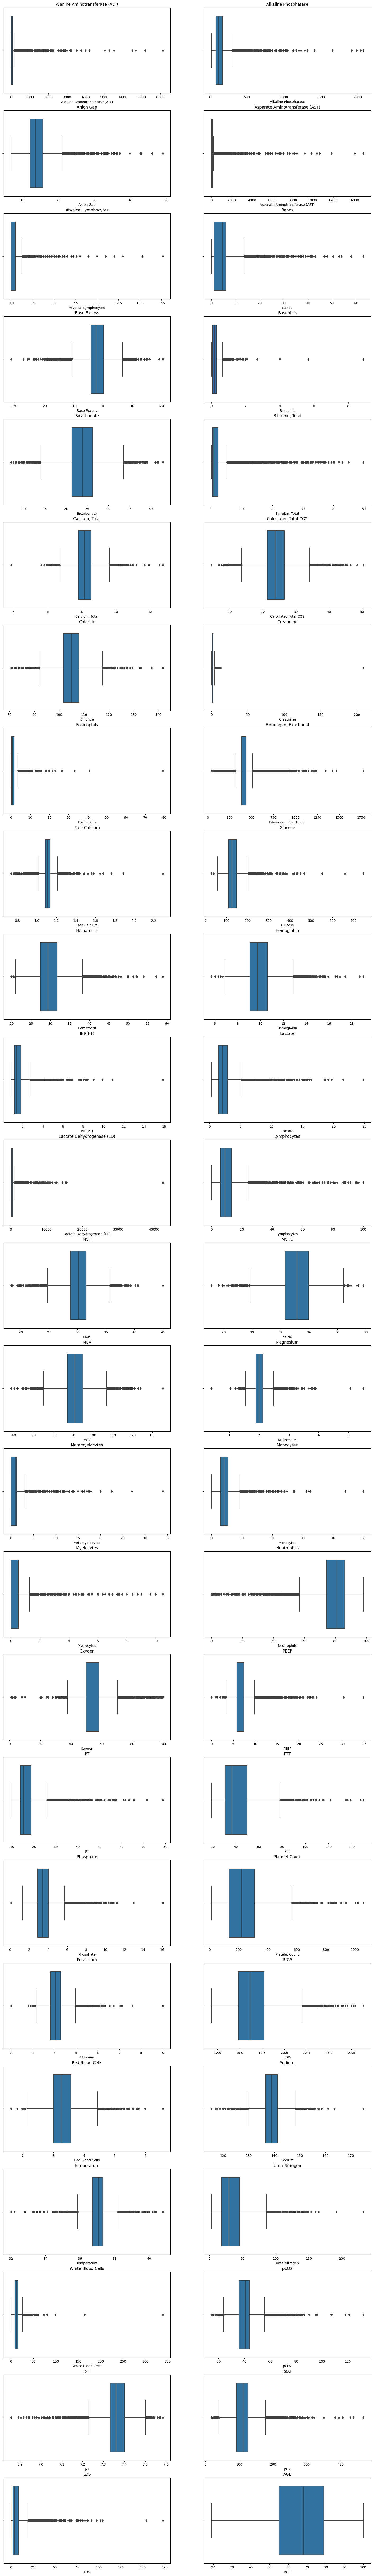

In [ ]:
# Create a boxplot for each numeric column

# Create subplots for each column
fig, axes = plt.subplots(nrows=25, ncols=2, figsize=(20, 140))

# Flatten the axes array to a list
axes = axes.flatten()

# Loop through each column and plot the boxplot
for i, col in enumerate(num_cols):
    sns.boxplot(x=final_ds[col], ax=axes[i])
    axes[i].set_title(col)

As we can see that each and every column of the dataframe have outliers in it, which can make our model biased. So let us mitigate that using winsorzing technique.

Winsorizing is a statistical technique used to deal with outliers in a dataset by adjusting extreme values to a specified percentile of the data. The approach involves setting the values above and below a certain percentile (usually the 1st and 99th or 5th and 95th percentiles) to the value at that percentile, effectively truncating the tails of the distribution. This technique can help to reduce the impact of outliers on summary statistics and model fitting, and can improve the overall robustness of the analysis. However, it should be used with caution, as it can also lead to loss of information and bias in the results if too many values are winsorized or if the chosen percentile is not appropriate for the data. Winsorizing can be applied to numerical data in a wide range of fields, including finance, economics, and healthcare.

In [ ]:
# Dealing with the outliers using winsorzing
# Percentage of data to be Winsorized (15%)
winsor_percent = 0.15

# Iterate over the columns with large maximum values
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for col in num_cols:
        if final_ds[col].max() > final_ds[col].quantile(0.75):
            print(f"Winsorizing column '{col}' with maximum value {final_ds[col].max()}")
            # Winsorize the column
            final_ds[col] = winsorize(final_ds[col], limits=(winsor_percent, winsor_percent))

Winsorizing column 'Alanine Aminotransferase (ALT)' with maximum value 8133.833333333333
Winsorizing column 'Alkaline Phosphatase' with maximum value 2075.8571428571427
Winsorizing column 'Anion Gap' with maximum value 49.0
Winsorizing column 'Asparate Aminotransferase (AST)' with maximum value 14929.5
Winsorizing column 'Atypical Lymphocytes' with maximum value 17.666666666666668
Winsorizing column 'Bands' with maximum value 63.0
Winsorizing column 'Base Excess' with maximum value 20.33333333333333
Winsorizing column 'Basophils' with maximum value 8.875
Winsorizing column 'Bicarbonate' with maximum value 42.888888888888886
Winsorizing column 'Bilirubin, Total' with maximum value 49.75454545454546
Winsorizing column 'Calcium, Total' with maximum value 12.75
Winsorizing column 'Calculated Total CO2' with maximum value 50.333333333333336
Winsorizing column 'Chloride' with maximum value 141.75
Winsorizing column 'Creatinine' with maximum value 208.55
Winsorizing column 'Eosinophils' with 

In [ ]:
final_ds[num_cols].describe()

Alanine Aminotransferase (ALT)  Alkaline Phosphatase     Anion Gap  \
count                    18851.000000          18851.000000  18851.000000   
mean                        50.749385            128.733640     13.982787   
std                         38.818094             55.500666      2.081907   
min                         14.200000             66.000000     11.364964   
25%                         18.250000             79.000000     12.105263   
50%                         33.560976            114.500000     13.677524   
75%                         78.500000            165.947368     15.692308   
max                        118.356034            224.000000     17.285714   

       Asparate Aminotransferase (AST)  Atypical Lymphocytes         Bands  \
count                     18851.000000          18851.000000  18851.000000   
mean                         75.197877              0.343411      4.410739   
std                          64.265668              0.316524      3.444799   
min                          21.000000              0.000000      0.000000   
25%                          26.333333              0.000000      1.000000   
50%                          44.868421              0.500000      4.500000   
75%                         102.884615              0.503856      6.000000   
max                         199.459562              0.857143     10.000000   

        Base Excess     Basophils   Bicarbonate  Bilirubin, Total  ...  \
count  18851.000000  18851.000000  18851.000000      18851.000000  ...   
mean      -1.901265      0.185372     23.796662          1.352418  ...   
std        2.633158      0.136932      2.750021          1.134448  ...   
min       -5.975000      0.000000     19.785714          0.333333  ...   
25%       -4.000000      0.066667     21.333333          0.429286  ...   
50%       -2.243243      0.175000     23.904762          0.800000  ...   
75%        0.294118      0.300000     26.257576          2.300000  ...   
max        1.857143      0.400000     27.625000          3.450000  ...   

       Red Blood Cells        Sodium   Temperature  Urea Nitrogen  \
count     18851.000000  18851.000000  18851.000000   18851.000000   
mean          3.291405    138.932375     37.050529      32.373108   
std           0.323839      2.619438      0.381039      14.868132   
min           2.866957    135.163265     36.479167      14.400000   
25%           2.994211    136.614591     36.733333      18.240000   
50%           3.255000    138.911765     37.065840      29.800000   
75%           3.573158    141.250000     37.318182      45.329897   
max           3.786667    142.658537     37.633333      55.857143   

       White Blood Cells          pCO2            pH           pO2  \
count       18851.000000  18851.000000  18851.000000  18851.000000   
mean           12.024924     40.085207      7.364844    109.998383   
std             3.753580      4.916261      0.040720     21.087145   
min             7.125455     33.062500      7.303404     79.666667   
25%             8.475000     35.800000      7.332899     92.000000   
50%            11.622222     40.620176      7.360000    111.553780   
75%            15.372300     43.748134      7.401615    126.560000   
max            17.698578     47.666667      7.422778    142.000000   

                LOS           AGE  
count  18851.000000  18851.000000  
mean       5.623134     67.134051  
std        4.497560     12.538590  
min        1.338500     49.000000  
25%        1.895200     55.000000  
50%        3.718900     68.000000  
75%        8.818600     79.000000  
max       13.775800     84.000000  

[8 rows x 50 columns]

As we can observe there is a great significant change in the difference between maximum and 75% row for each of the column present in the dataframe.

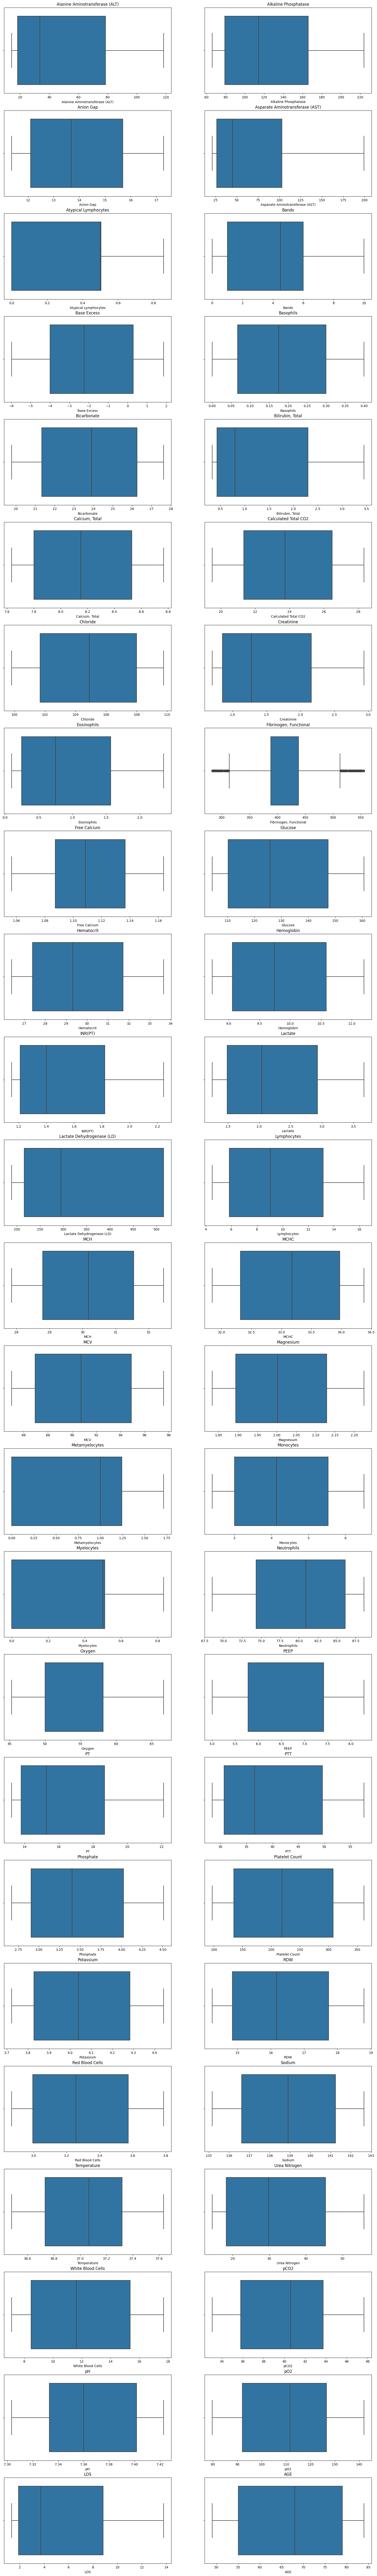

In [ ]:
# Create a boxplot for each numeric column
# Create subplots for each column
fig, axes = plt.subplots(nrows=25, ncols=2, figsize=(20, 140))

# Flatten the axes array to a list
axes = axes.flatten()

# Loop through each column and plot the boxplot
for i, col in enumerate(num_cols):
    sns.boxplot(x=final_ds[col], ax=axes[i])
    axes[i].set_title(col)

As, we can see that now our histograms looks outlier free and ready for our analysis. We also have to note that 'Glucose' have outliers after the application of technique too. We would eliminate this issue going further.

100%|██████████| 50/50 [00:04<00:00, 10.55it/s]


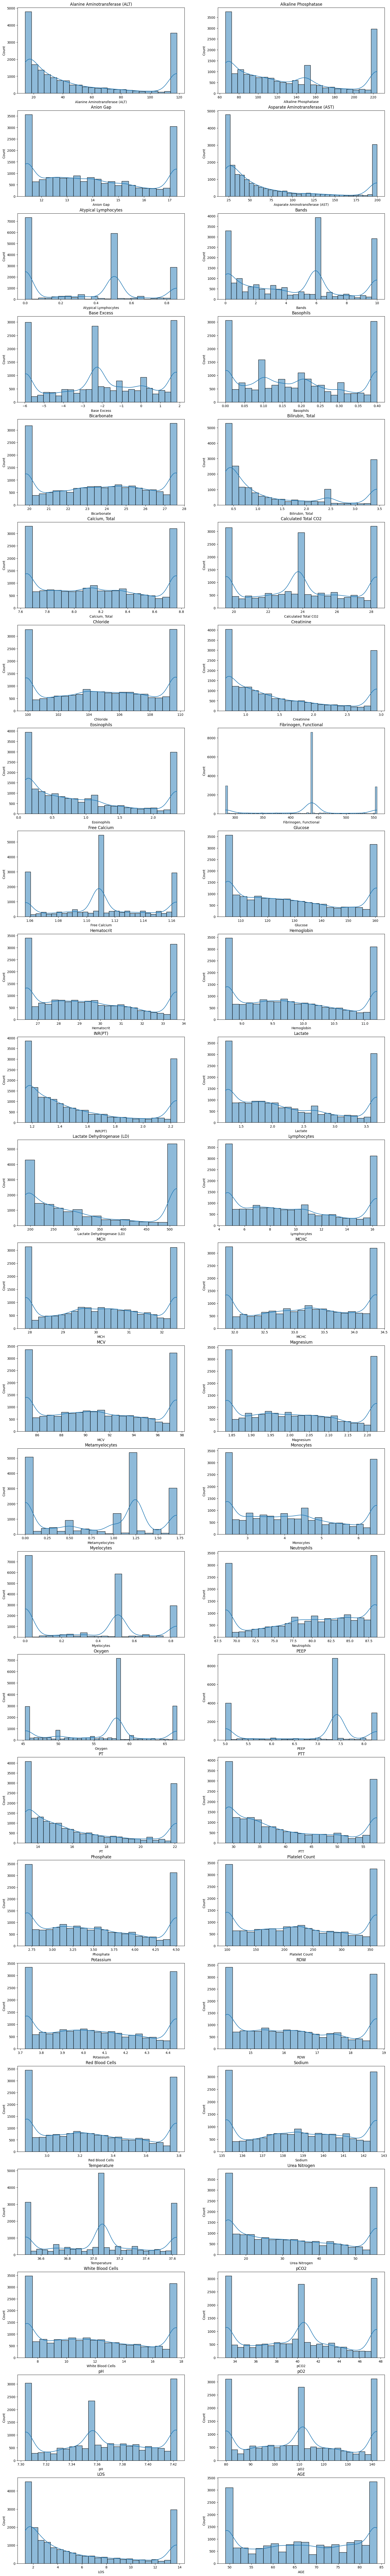

In [ ]:
#Plotting the historgram for all the numerical columns
# Create subplots for each column
fig, axes = plt.subplots(nrows=25, ncols=2, figsize=(20, 140))

# Flatten the axes array to a list
axes = axes.flatten()

# Loop through each column and plot the histogram and kde
#Using tqdm to see the progress bar
for i, col in tqdm(enumerate(num_cols), total=len(num_cols)):
    sns.histplot(final_ds[col], kde=True, ax=axes[i])
    axes[i].set_title(col)

In our course deep learning, the assumption of normality in the distribution of input data may not be as critical as in some other statistical methods. Deep learning models, such as neural networks, can be quite flexible and able to learn complex relationships in the data, even if the distributions of individual variables are not normal. However, it is still important to examine the data and consider the impact of non-normality on the analysis. For example, non-normality may affect the stability and convergence of the model, and may require special handling or transformations of the data. In some cases, it may be appropriate to normalize the data to make the distributions more normal, or to use alternative models or methods that are more robust to non-normality. Ultimately, the best approach will depend on the specific problem, data, and goals of the analysis.

In [ ]:
# Now, Let's scale our data such that all the features have a common scale
# Create a StandardScaler object
scaler = StandardScaler()

# Normalize the numerical columns
final_ds[num_cols] = scaler.fit_transform(final_ds[num_cols])

StandardScaler is used to standardize/normalize the data to have a mean of 0 and a standard deviation of 1. It is commonly used in machine learning models to ensure that all features are on the same scale and have equal importance during model training.

In the case of Winsorizing, the technique is used to deal with outliers by replacing them with a specific value such as the nearest valid value within a specified range. However, this can cause the data to lose its original distribution, and in some cases, the mean and standard deviation may change. Therefore, using StandardScaler after Winsorizing can help to normalize the data while maintaining the effects of Winsorizing, resulting in better model performance.

By using StandardScaler after Winsorizing, the data is still on the same scale, but any previously extreme values are now replaced with a more reasonable value. It is important to note that the order of performing Winsorizing and StandardScaler may differ depending on the dataset and specific use case.

In [ ]:
#Displaying the skewness for every numerical columns
for i in num_cols:
    print(f'Skewness for the {i} is : {skew(final_ds[i])}')

Skewness for the Alanine Aminotransferase (ALT) is : 0.819832653279492
Skewness for the Alkaline Phosphatase is : 0.5524101467857637
Skewness for the Anion Gap is : 0.3205130941464545
Skewness for the Asparate Aminotransferase (AST) is : 1.090085615859956
Skewness for the Atypical Lymphocytes is : 0.23738482623771526
Skewness for the Bands is : 0.24818600614970077
Skewness for the Base Excess is : -0.11006155676097865
Skewness for the Basophils is : 0.22762120053172583
Skewness for the Bicarbonate is : -0.06902670897470435
Skewness for the Bilirubin, Total is : 0.8829128809763213
Skewness for the Calcium, Total is : 0.12753484355439348
Skewness for the Calculated Total CO2 is : 0.02594985697437585
Skewness for the Chloride is : -0.034067853171794144
Skewness for the Creatinine is : 0.6566442949301098
Skewness for the Eosinophils is : 0.6038589942721196
Skewness for the Fibrinogen, Functional is : -0.2709058671451967
Skewness for the Free Calcium is : 0.01937169841475098
Skewness for th

Skewness is a measure of the asymmetry of the probability distribution of a variable. A skewness value of zero indicates that the data is perfectly symmetrical, while positive skewness indicates that the tail of the distribution is longer on the positive side. In contrast, negative skewness indicates that the tail is longer on the negative side. Based on the provided skewness values, we can see that many of the variables have positive skewness, including ALT, AST, Bilirubin Total, and LOS, which suggests that these variables have a longer right tail and are skewed towards higher values. Conversely, some variables such as Neutrophils, PEEP, and Fibrinogen Functional exhibit negative skewness, indicating that their distributions are skewed towards lower values. Other variables such as Anion Gap and Calcium Total have skewness values closer to zero, indicating relatively symmetrical distributions. Overall, these skewness values provide insight into the distributional properties of the variables and can help in selecting appropriate statistical tests and modeling techniques.

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # Calculate VIF for each numerical column
    vif_data = pd.DataFrame()
    vif_data["feature"] = num_cols
    vif_data["VIF"] = [variance_inflation_factor(final_ds[num_cols].values, i)
                       for i in range(len(num_cols))]
    
    # Print VIF values for each feature
    print(vif_data)

                            feature        VIF
0    Alanine Aminotransferase (ALT)   4.938366
1              Alkaline Phosphatase   1.316584
2                         Anion Gap   4.107046
3   Asparate Aminotransferase (AST)   5.709702
4              Atypical Lymphocytes   1.168397
5                             Bands   1.634164
6                       Base Excess  21.191991
7                         Basophils   1.517884
8                       Bicarbonate   5.238640
9                  Bilirubin, Total   1.926972
10                   Calcium, Total   1.591022
11             Calculated Total CO2  22.747940
12                         Chloride   5.303484
13                       Creatinine   3.150312
14                      Eosinophils   1.582526
15           Fibrinogen, Functional   1.275982
16                     Free Calcium   1.368734
17                          Glucose   1.154290
18                       Hematocrit  22.311876
19                       Hemoglobin  21.352311
20           

In [ ]:
# Get summary statistics of VIF values
print(vif_data['VIF'].describe())

count    50.000000
mean      5.042210
std       6.215264
min       1.154290
25%       1.417153
50%       1.808449
75%       4.932286
max      22.747940
Name: VIF, dtype: float64


As we can from the above description of VIF, the maximum is around 22 which implies that there is a high degree of correlation among the predictor variables in the model, indicating a potential problem of multicollinearity. This can lead to unreliable regression coefficients, inflated standard errors, and decreased predictive power of the model. Typically, a VIF value of 10 or higher is considered a cause for concern and may require further investigation or remedial action, such as removing highly correlated predictors or using regularization techniques.

In [ ]:
# Calculate the 75th percentile of VIF values
vif_thresh = vif_data['VIF'].quantile(0.75)

# Filter the rows with VIF values above the threshold
high_vif = vif_data[vif_data['VIF'] > vif_thresh]

# Get the count of features with VIF values above the threshold
high_vif_count = len(high_vif)
print("Number of features with VIF values above the 75th percentile: ", high_vif_count)

# Drop the columns with VIF values above the threshold from final_ds
final_ds.drop(columns=high_vif['feature'], inplace=True)
print("Number of columns in final_ds after dropping columns with VIF values above the 75th percentile: ", len(final_ds.columns))


Number of features with VIF values above the 75th percentile:  13
Number of columns in final_ds after dropping columns with VIF values above the 75th percentile:  46


Using the above code we have removed the columns with higher VIF because it may lead to multicollinearity and effect the model

In [ ]:
#Creating a new columns to store the numerical column names
num_cols1 = list(final_ds.select_dtypes(include=['float64', 'int64']).columns)

#Removing SUBJECT_ID, even it is integer but it wont help us in the model building
num_cols1.remove('SUBJECT_ID')

#Removing DEATH_WITHIN_90_DAYS, as it is our label value
num_cols1.remove('DEATH_WITHIN_90_DAYS')

#Removing DEATH_WITHIN_60_DAYS, as it is our label value
num_cols1.remove('DEATH_WITHIN_60_DAYS')

#Removing DEATH_WITHIN_30_DAYS, as it is our label value
num_cols1.remove('DEATH_WITHIN_30_DAYS')

print("Length of the numerical columns : ", len(num_cols1))

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # Calculate VIF for each numerical column
    vif_data = pd.DataFrame()
    vif_data["feature"] = num_cols1
    vif_data["VIF"] = [variance_inflation_factor(final_ds[num_cols1].values, i)
                       for i in range(len(num_cols1))]
    
    # Print VIF values for each feature
    print(vif_data)

Length of the numerical columns :  37
                       feature       VIF
0         Alkaline Phosphatase  1.225450
1                    Anion Gap  2.735569
2         Atypical Lymphocytes  1.157291
3                        Bands  1.622125
4                    Basophils  1.506207
5             Bilirubin, Total  1.629995
6               Calcium, Total  1.424880
7                   Creatinine  3.070513
8                  Eosinophils  1.563668
9       Fibrinogen, Functional  1.261625
10                Free Calcium  1.302677
11                     Glucose  1.144886
12                     Lactate  1.619065
13  Lactate Dehydrogenase (LD)  1.164518
14                 Lymphocytes  3.067527
15                        MCHC  1.448817
16                   Magnesium  1.370599
17              Metamyelocytes  1.795411
18                   Monocytes  1.432668
19                  Myelocytes  1.653716
20                 Neutrophils  3.396599
21                      Oxygen  1.195164
22                 

In [ ]:
print(vif_data['VIF'].describe())

count    37.000000
mean      1.650934
std       0.625253
min       1.144886
25%       1.261625
50%       1.448817
75%       1.629995
max       3.396599
Name: VIF, dtype: float64


The mean VIF is 1.65, which indicates that, on average, the variables in the dataset are not highly correlated with each other. The standard deviation of 0.63 suggests that the variance in the VIF values is moderate. The minimum VIF value of 1.14 indicates that there are some variables that have low multicollinearity with other variables. The maximum VIF value of 3.40 indicates that there are some variables that have a high correlation with other variables, which may impact the accuracy and reliability of regression models that include these variables. The quartile ranges suggest that most of the variables have VIF values below 1.63, and the median VIF value of 1.45 further supports this finding. Overall, the VIF statistics suggest that while there is some multicollinearity present in the dataset, it is not severe enough to significantly impact the analysis results.

In [ ]:
# Calculate the kurtosis of each numerical column
kurtosis = final_ds[num_cols1].kurtosis()

# Print the kurtosis values
print(kurtosis)

Alkaline Phosphatase         -1.050324
Anion Gap                    -1.241895
Atypical Lymphocytes         -1.317376
Bands                        -1.193655
Basophils                    -1.205370
Bilirubin, Total             -0.780002
Calcium, Total               -1.333224
Creatinine                   -1.019299
Eosinophils                  -1.037173
Fibrinogen, Functional       -0.601066
Free Calcium                 -0.930793
Glucose                      -1.292167
Lactate                      -1.151095
Lactate Dehydrogenase (LD)   -1.536654
Lymphocytes                  -1.240205
MCHC                         -1.344326
Magnesium                    -1.285412
Metamyelocytes               -1.463930
Monocytes                    -1.275419
Myelocytes                   -1.412173
Neutrophils                  -1.188164
Oxygen                       -0.900784
PEEP                         -0.949080
PTT                          -1.185724
Phosphate                    -1.245513
Platelet Count           

The above kurtosis values indicate the degree of peakedness and tail-heaviness of the distributions of different laboratory tests. All of the variables have negative kurtosis values, indicating that they are all platykurtic, i.e., they have thinner tails and less extreme values than a normal distribution. The kurtosis values range from -1.05 to -1.54, with Lactate Dehydrogenase (LD) having the highest kurtosis value and Fibrinogen, Functional having the lowest. This indicates that the distribution of LD is more peaked and has thicker tails than Fibrinogen, Functional. Overall, the kurtosis values suggest that the distributions of these laboratory tests are relatively close to a normal distribution, with thinner tails and less extreme values. However, they are still slightly different from a normal distribution, which is important to consider when performing statistical analyses.

In [ ]:
print(final_ds.shape)
final_ds.head()

(18851, 46)


SUBJECT_ID  Alkaline Phosphatase  Anion Gap  Atypical Lymphocytes  \
0          234             -0.463676   1.586533             -1.084974   
12         250              0.703008  -0.387307              1.623084   
18         395             -1.130352  -0.712244             -1.084974   
23         419              1.449865  -1.174889             -1.084974   
28         441              1.255376   0.975486              1.021294   

       Bands  Basophils  Bilirubin, Total  Calcium, Total  Creatinine  \
0  -1.280439  -0.258324         -0.898332        0.748620    1.736071   
12  1.622565  -1.353784         -0.516345        0.356769   -1.060792   
18  1.622565   0.350264         -0.898332        0.315083   -0.654718   
23  0.712957  -1.145125          1.741997        0.478425   -1.060792   
28  0.422656  -0.866913          0.604495        1.482298    0.207824   

    Eosinophils  ...    CATEGORY  FIRST_CAREUNIT  LAST_CAREUNIT       LOS  \
0     -0.556065  ...  Hematology             CCU            CCU -0.102710   
12    -1.087172  ...  Hematology            MICU           CSRU  1.121252   
18     1.724570  ...  Hematology            MICU           MICU -0.952683   
23    -0.997911  ...  Hematology            MICU           SICU  1.812735   
28     1.370499  ...  Hematology            MICU           SICU  1.812735   

    ADMISSION_TYPE  GENDER       AGE  DEATH_WITHIN_90_DAYS  \
0        EMERGENCY       M -1.207030                     0   
12       EMERGENCY       F -1.446298                     1   
18       EMERGENCY       F  0.547600                     0   
23       EMERGENCY       F -0.648739                     0   
28       EMERGENCY       F -1.446298                     0   

    DEATH_WITHIN_60_DAYS  DEATH_WITHIN_30_DAYS  
0                      0                     0  
12                     1                     1  
18                     0                     0  
23                     0                     0  
28                     0                     0  

[5 rows x 46 columns]

C:\Users\bduser\AppData\Local\Temp\ipykernel_29836\1771994219.py:11: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = corr_df.corr()


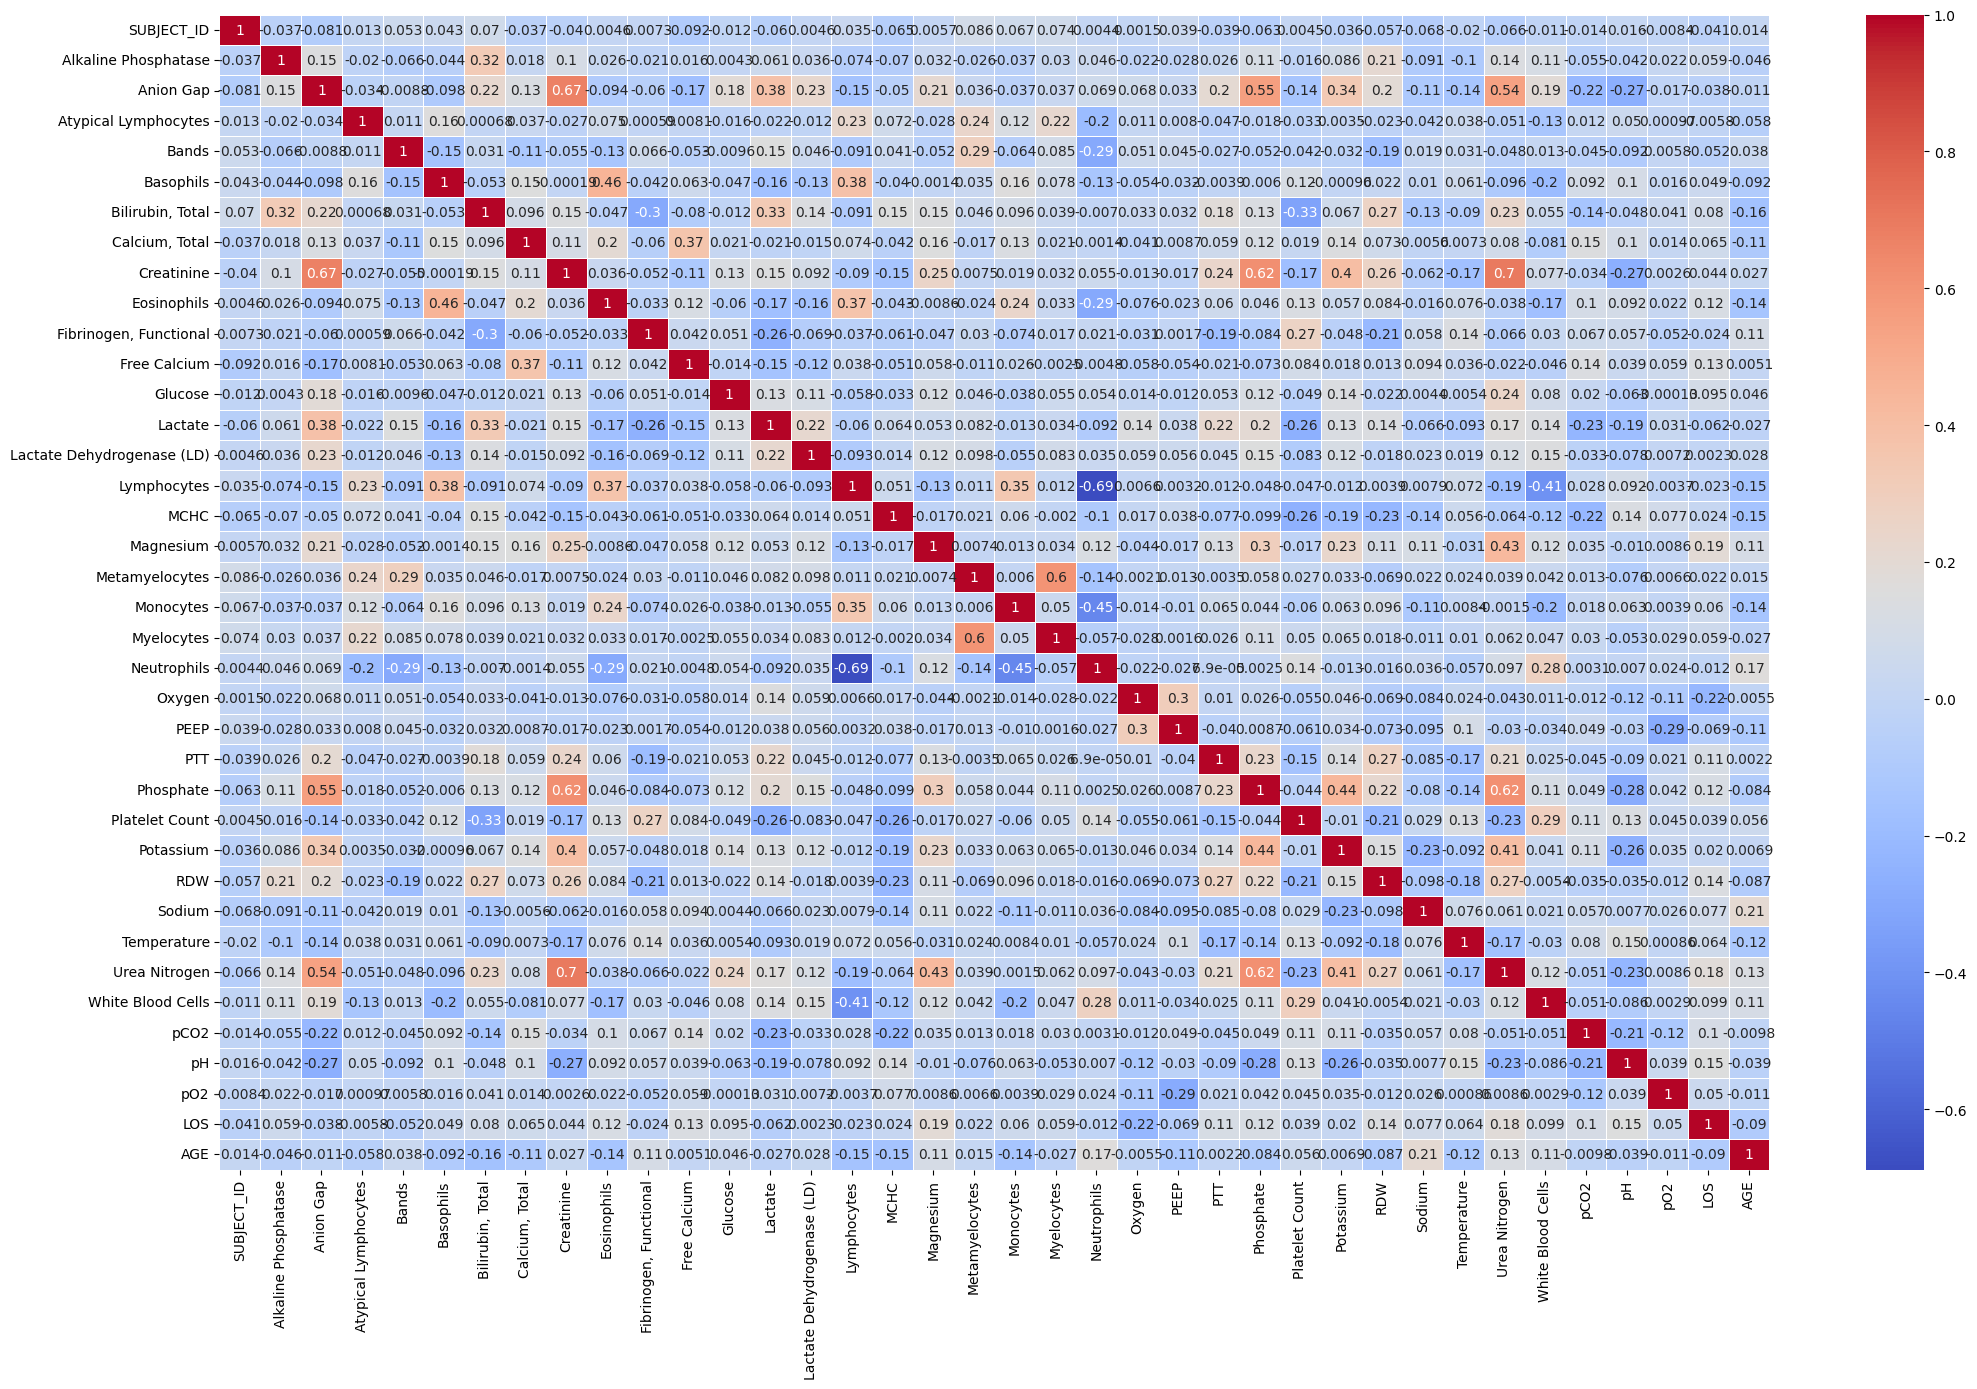

In [ ]:
# columns to exclude from the list
exclude_cols = ['DEATH_WITHIN_90_DAYS', 'DEATH_WITHIN_60_DAYS', 'DEATH_WITHIN_30_DAYS']

# create a list of all columns in final_ds except for the excluded columns
cols = [col for col in final_ds.columns if col not in exclude_cols]

# select the columns from final_ds
corr_df = final_ds[cols]

# calculate the correlation matrix
corr_matrix = corr_df.corr()

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(25, 15))

# Generate a heatmap with the correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

# Show the plot
plt.show()

The correlation matrix indicates the strength of the linear relationship between pairs of features. In this case, if there are features with a correlation coefficient higher than 0.5, it means that they are highly correlated and may provide redundant information. Therefore, it could be proposed to remove one of the features to avoid multicollinearity in the model. This would help to improve the interpretability of the model and reduce overfitting.

In [ ]:
# Set the correlation threshold
corr_threshold = 0.5

# Create an empty list to store correlated features
correlated_features = []

# Calculate the correlation matrix
corr_matrix1 = corr_matrix.abs()

# Iterate through the correlation matrix and find correlated features
for i in range(len(corr_matrix1.columns)):
    for j in range(i):
        if corr_matrix1.iloc[i, j] > corr_threshold:
            feature_i = corr_matrix1.columns[i]
            feature_j = corr_matrix1.columns[j]
            correlated_features.append((feature_i, feature_j))

# Print the list of correlated features
print(correlated_features)

[('Creatinine', 'Anion Gap'), ('Myelocytes', 'Metamyelocytes'), ('Neutrophils', 'Lymphocytes'), ('Phosphate', 'Anion Gap'), ('Phosphate', 'Creatinine'), ('Urea Nitrogen', 'Anion Gap'), ('Urea Nitrogen', 'Creatinine'), ('Urea Nitrogen', 'Phosphate')]


We have printed the pair of features having higher correaltion to decide on which feature to drop further of our analysis

In [ ]:
# Create an empty list to store the columns to be dropped
cols_to_drop = []

# Loop through each pair of correlated features
for feature_pair in correlated_features:
    feature_i = feature_pair[0]
    feature_j = feature_pair[1]
    
    # Calculate the VIF for each feature
    vif_i = variance_inflation_factor(final_ds[[feature_i, feature_j]].values, 0)
    vif_j = variance_inflation_factor(final_ds[[feature_i, feature_j]].values, 1)
    
    # Calculate the skewness for each feature
    skew_i = skew(final_ds[feature_i])
    skew_j = skew(final_ds[feature_j])
    
    # Determine which feature to drop based on VIF and skewness
    if vif_i > vif_j:
        cols_to_drop.append(feature_i)
    elif vif_i < vif_j:
        cols_to_drop.append(feature_j)
    else:
        if skew_i > skew_j:
            cols_to_drop.append(feature_i)
        else:
            cols_to_drop.append(feature_j)
            
# Drop the columns from final_ds
print(cols_to_drop)
final_ds = final_ds.drop(cols_to_drop, axis=1)

['Anion Gap', 'Metamyelocytes', 'Lymphocytes', 'Anion Gap', 'Creatinine', 'Anion Gap', 'Creatinine', 'Phosphate']


We implementing a technique to drop features that are highly correlated and have high variance inflation factor (VIF) and skewness. Our code loops through each pair of correlated features and calculates the VIF and skewness for each feature. Based on the VIF and skewness values, the code determines which feature to drop and appends it to the list of columns to be dropped. Finally, it drops the columns from the final dataset. This technique is useful for reducing multicollinearity and improving the performance of predictive models. By removing highly correlated features, we can simplify the model and reduce overfitting, while still retaining the most informative features.

In [ ]:
print(final_ds.shape)
final_ds.head()

(18851, 41)


SUBJECT_ID  Alkaline Phosphatase  Atypical Lymphocytes     Bands  \
0          234             -0.463676             -1.084974 -1.280439   
12         250              0.703008              1.623084  1.622565   
18         395             -1.130352             -1.084974  1.622565   
23         419              1.449865             -1.084974  0.712957   
28         441              1.255376              1.021294  0.422656   

    Basophils  Bilirubin, Total  Calcium, Total  Eosinophils  \
0   -0.258324         -0.898332        0.748620    -0.556065   
12  -1.353784         -0.516345        0.356769    -1.087172   
18   0.350264         -0.898332        0.315083     1.724570   
23  -1.145125          1.741997        0.478425    -0.997911   
28  -0.866913          0.604495        1.482298     1.370499   

    Fibrinogen, Functional  Free Calcium  ...    CATEGORY  FIRST_CAREUNIT  \
0                 0.143310     -0.049379  ...  Hematology             CCU   
12               -0.551557      1.538489  ...  Hematology            MICU   
18                0.143310     -0.049379  ...  Hematology            MICU   
23                1.533998      0.798337  ...  Hematology            MICU   
28               -1.692896      1.538489  ...  Hematology            MICU   

    LAST_CAREUNIT       LOS  ADMISSION_TYPE  GENDER       AGE  \
0             CCU -0.102710       EMERGENCY       M -1.207030   
12           CSRU  1.121252       EMERGENCY       F -1.446298   
18           MICU -0.952683       EMERGENCY       F  0.547600   
23           SICU  1.812735       EMERGENCY       F -0.648739   
28           SICU  1.812735       EMERGENCY       F -1.446298   

    DEATH_WITHIN_90_DAYS  DEATH_WITHIN_60_DAYS  DEATH_WITHIN_30_DAYS  
0                      0                     0                     0  
12                     1                     1                     1  
18                     0                     0                     0  
23                     0                     0                     0  
28                     0                     0                     0  

[5 rows x 41 columns]

In [ ]:
final_ds.to_csv('final_dataframe.csv', index=False)

Converting our Final Dataframe into csv file for further use and analysis.

### Methodology

Our project aimed to predict the mortality of patients diagnosed with sepsis using deep learning models. We followed a standard deep learning process consisting of data preprocessing, model training, and evaluation.

Data preprocessing: We started by preprocessing the MIMIC-III data of patients diagnosed with sepsis. We filtered out irrelevant features, handled missing values, and standardized the data. We also split the data into training, validation, and testing sets.

Model training: We trained three deep neural network models to predict mortality based on the preprocessed data. The models we used were Convolutional Neural Networks (CNNs), Gated Recurrent Units (GRUs), and Long Short-Term Memory (LSTM) networks. We chose these models because they are commonly used for sequential data analysis, and MIMIC data is a type of sequential data.

Model evaluation: We evaluated the performance of each model on the testing set by calculating several performance metrics such as accuracy, precision, recall, and F1 score. We also calculated the area under the receiver operating characteristic curve (AUC-ROC) to evaluate the models' ability to distinguish between positive and negative classes. Finally, we compared the performance of the individual models with an ensemble method to improve the overall prediction accuracy.

Deep Neural Networks:

Model 1: Convolutional Neural Networks (CNNs)
A convolutional neural network (CNN or ConvNet) is a type of neural network that is commonly used for classification tasks. CNNs are designed to recognize patterns in data by using convolutional layers to extract features from the input data. In our project, we used 1D CNNs to extract relevant features from the MIMIC data.

Model 2: Gated Recurrent Units (GRUs)
Gated Recurrent Units (GRUs) are a type of recurrent neural network (RNN) that is commonly used for sequential data analysis. GRUs are designed to overcome the vanishing gradient problem in traditional RNNs by using gating mechanisms to selectively update and reset the hidden state. In our project, we used GRUs to model the temporal dependencies in the MIMIC data.

Model 3: Long Short-Term Memory (LSTM) networks
Long Short-Term Memory (LSTM) networks are another type of recurrent neural network that is commonly used for sequential data analysis. LSTMs are designed to overcome the vanishing gradient problem and the exploding gradient problem in traditional RNNs by using memory cells and gating mechanisms to selectively update and forget information over time. In our project, we used LSTMs to model the long-term dependencies in the MIMIC data.

Keywords: electronic health record, mortality prediction, deep learning, convolutional neural networks, gated recurrent units, long short-term memory, sequential data, performance metrics, area under the receiver operating characteristic curve, ensemble method.

In [ ]:
# Read the CSV file
final_ds = pd.read_csv('final_dataframe.csv')

final_ds['CATEGORY'] = final_ds['CATEGORY'].astype('category')
final_ds['FIRST_CAREUNIT'] = final_ds['FIRST_CAREUNIT'].astype('category')
final_ds['LAST_CAREUNIT'] = final_ds['LAST_CAREUNIT'].astype('category')
final_ds['ADMISSION_TYPE'] = final_ds['ADMISSION_TYPE'].astype('category')
final_ds['GENDER'] = final_ds['GENDER'].astype('category')

# Perform multi-label encoding on 'LAST_CAREUNIT'
category_encoded = pd.get_dummies(final_ds['CATEGORY'], prefix='CATEGORY')
first_careunit_encoded = pd.get_dummies(final_ds['FIRST_CAREUNIT'], prefix='FIRST_CAREUNIT')
last_careunit_encoded = pd.get_dummies(final_ds['LAST_CAREUNIT'], prefix='LAST_CAREUNIT')
admission_type_encoded = pd.get_dummies(final_ds['ADMISSION_TYPE'], prefix='ADMISSION_TYPE')
gender_encoded = pd.get_dummies(final_ds['GENDER'], prefix='GENDER')

# Drop original 'LAST_CAREUNIT' column and concatenate the encoded columns to the final_ds dataframe
final_ds.drop('CATEGORY', axis=1, inplace=True)
final_ds = pd.concat([final_ds, category_encoded], axis=1)
final_ds.drop('FIRST_CAREUNIT', axis=1, inplace=True)
final_ds = pd.concat([final_ds, first_careunit_encoded], axis=1)
final_ds.drop('LAST_CAREUNIT', axis=1, inplace=True)
final_ds = pd.concat([final_ds, last_careunit_encoded], axis=1)
final_ds.drop('ADMISSION_TYPE', axis=1, inplace=True)
final_ds = pd.concat([final_ds, admission_type_encoded], axis=1)
final_ds.drop('GENDER', axis=1, inplace=True)
final_ds = pd.concat([final_ds, gender_encoded], axis=1)

In [ ]:
# Select a random subset of 10 records
random_subset = final_ds.sample(n=10, random_state=random.seed())

#Dropping the target variables from the random subset chosen
random_subset = random_subset.drop(['DEATH_WITHIN_90_DAYS',
                                    'DEATH_WITHIN_60_DAYS', 'DEATH_WITHIN_30_DAYS'], axis=1)

# Save the selected records to a new CSV file
random_subset.to_csv('demo_file.csv', index=False)

# Drop the selected 10 rows from the original dataframe
final_ds.drop(index=random_subset.index, inplace=True)

### Model Fitting and Validation

In order to tackle the binary classification problem, three models, namely Convolutional Neural Networks (CNN), Gated Recurrent Unit (GRU) and Long Short-Term Memory (LSTM) have been fitted and compared.

The first model (model 1) is a GRU model with 32 units, followed by a dropout layer with a rate of 0.2 and a dense output layer with a sigmoid activation function. The model has been compiled with an Adam optimizer, binary cross-entropy loss function and accuracy metrics. The model has been trained on the training set for 50 epochs with a batch size of 64 and validated on the validation set. Finally, the model has been evaluated on the test set, and the test accuracy has been printed.

The second model (model 2) is an LSTM model with 64 units in the first layer, followed by a dropout layer with a rate of 0.2. The second layer consists of 32 units, and it is followed by a dropout layer with a rate of 0.2. The output layer has a sigmoid activation function.

The third model (model 3) is a CNN model with two convolutional layers, each followed by a max-pooling layer and a batch normalization layer. The first convolutional layer has 32 filters, and the second convolutional layer has 64 filters. The output of the second max-pooling layer is then flattened and passed through two dense layers, each followed by a dropout layer. The final output layer has a sigmoid activation function.

By fitting and comparing these three models, we can select the one that yields the highest accuracy on the test set and use it for predicting on unseen data.

In [ ]:
#class counts
class_counts1 = final_ds['DEATH_WITHIN_90_DAYS'].value_counts()
print(class_counts1)

# Separate the target variable from the features
X1 = final_ds.drop(['DEATH_WITHIN_90_DAYS','DEATH_WITHIN_60_DAYS', 'DEATH_WITHIN_30_DAYS'], axis=1)
y1 = final_ds['DEATH_WITHIN_90_DAYS']

# Balance the dataset using RandomOverSampler
oversampler = RandomOverSampler(random_state=42)
X1, y1 = oversampler.fit_resample(X1, y1)

#class counts after RandomOverSampler
class_counts3 = pd.Series(y1).value_counts()
print(class_counts3)

# Split the data into training, validation, and testing sets
X_train, X_val_test, y_train, y_val_test = train_test_split(X1, y1, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

# Define the model architecture
keras.backend.clear_session()
model1 = Sequential()
model1.add(GRU(units=32, input_shape=(X_train.shape[1], 1)))
model1.add(Dropout(rate=0.2))
model1.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history1 = model1.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val), verbose=0)

# Evaluate the model on the test set
test_loss, test_acc = model1.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

0    12866
1     5975
Name: DEATH_WITHIN_90_DAYS, dtype: int64
0    12866
1    12866
Name: DEATH_WITHIN_90_DAYS, dtype: int64
121/121 [==============================] - 0s 2ms/step - loss: 0.5081 - accuracy: 0.7575
Test accuracy: 0.7575129270553589


The initial class counts show an imbalance in the target variable, with a significantly higher number of patients surviving beyond 90 days. To balance the dataset, the RandomOverSampler technique is applied, resulting in an equal number of patients in both the positive and negative classes. The model architecture chosen is a GRU neural network with a dropout layer to prevent overfitting. The model is trained on the balanced dataset and evaluated on the test set, which shows a test accuracy of 75.75%. This indicates that the model has learned to predict with a reasonable accuracy whether a patient is likely to die within 90 days of hospitalization based on the given features.

In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 32)                3360      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 3,393
Trainable params: 3,393
Non-trainable params: 0
_________________________________________________________________


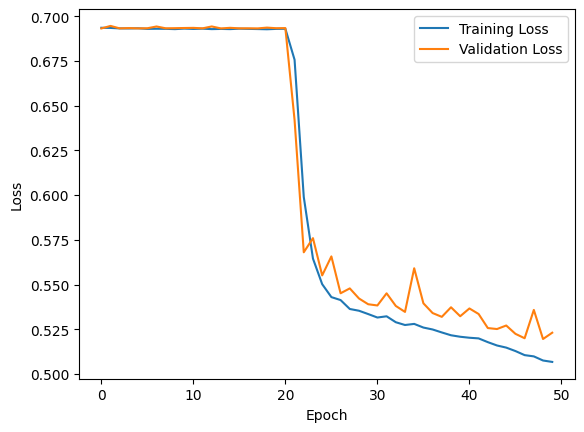

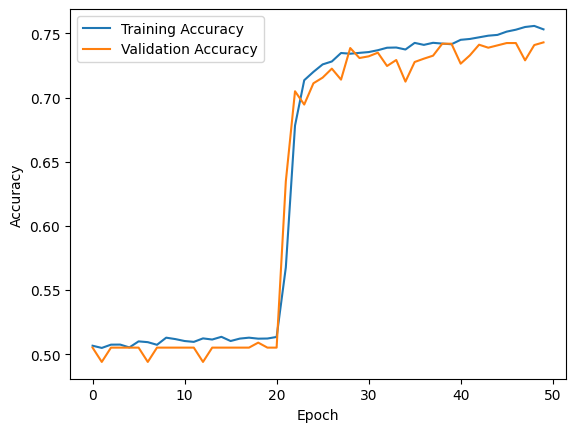

121/121 [==============================] - 0s 2ms/step


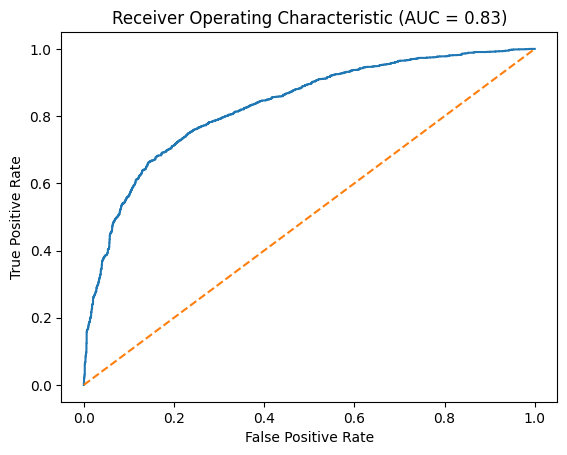

In [ ]:
# Plot the training and validation losses
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracies
plt.plot(history1.history['accuracy'], label='Training Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Predict probabilities for the test set
y_pred_prob = model1.predict(X_test)

# Calculate the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_pred_prob)

# Plot the ROC curve
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (AUC = {auc_score:.2f})')
plt.show()

For the above GRU Baseline model, No overfitting is observed but it started learning patterns in the data only after 20 epochs and we can see the training and validation losses reducing steeply from that point.An AUC (Area Under the Curve) of 0.83 indicates that the model has some ability to distinguish between positive and negative samples. However, an AUC of 0.5 represents random guessing, so the model's performance is only slightly better than guessing. Therefore, while an AUC of 0.83 is not a bad score, there is still room for improvement in the model's ability to accurately predict the outcome.

121/121 [==============================] - 0s 2ms/step


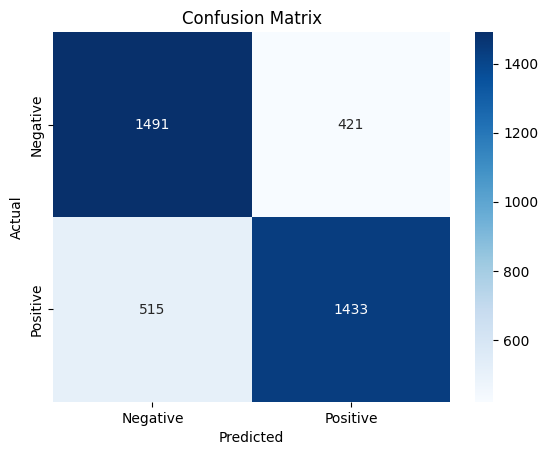

Sensitivity (TPR): 0.736
Specificity (TNR): 0.780


In [ ]:
# Get the model's predictions on the test set
y_pred = model1.predict(X_test)
y_pred_classes = np.round(y_pred).flatten().astype(int)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Getting the model's Sensitivity and Specificity:
# Extract true positive, true negative, false positive, and false negative from the confusion matrix
tn, fp, fn, tp = cm.ravel()

# Calculate sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# Print the results
print(f'Sensitivity (TPR): {sensitivity:.3f}')
print(f'Specificity (TNR): {specificity:.3f}')

Based on the given results, the sensitivity (True Positive Rate) is 0.736, which means that out of all the actual positive cases, the model is able to correctly identify 73.6% of them as positive. On the other hand, the specificity (True Negative Rate) is 0.780, which means that out of all the actual negative cases, the model is able to correctly identify 78.0% of them as negative. These results indicate that the model is performing reasonably well in identifying both positive and negative cases, although there is some room for improvement. It is also important to note that the performance of the model can vary depending on the threshold used for classification and other factors such as the dataset used for training and testing.

## GRU KERAS TUNER

In [ ]:
# Here were are building a model based on our hyper parameter
def model_builder(hp):
    keras.backend.clear_session()
    model = Sequential()
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    model.add(GRU(units=hp_units, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(rate=0.2))
    model.add(Dense(units=1, activation='sigmoid'))
    # Now, Let's tune the learning rate for the optimizer ADAM
    # Choose an optimal value from the 0.01, 0.001, or 0.0001 values
    hp_lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    # Compile the model
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_lr),
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])
    return model

In [ ]:
tuner = kt.Hyperband(model_builder, objective='val_accuracy', max_epochs=50, 
                     directory='project_gru_dp', project_name='intro_to_kt')
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(X_train, y_train, epochs=50, batch_size=64, 
             validation_data=(X_val, y_val), callbacks=[stop_early])
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 90 Complete [00h 01m 22s]
val_accuracy: 0.9658030867576599

Best val_accuracy So Far: 0.9769430160522461
Total elapsed time: 00h 22m 00s
INFO:tensorflow:Oracle triggered exit


121/121 [==============================] - 0s 2ms/step - loss: 0.1384 - accuracy: 0.9573
Test accuracy: 0.9572538733482361


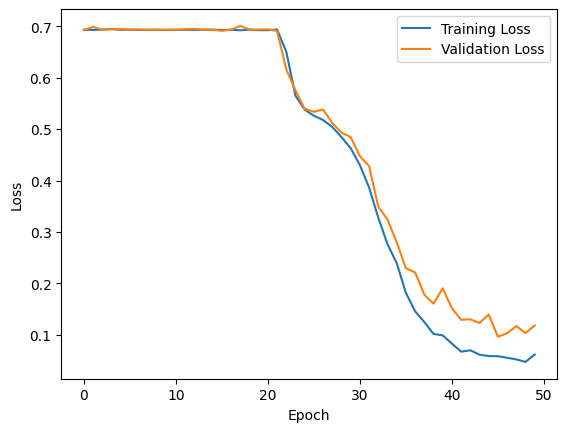

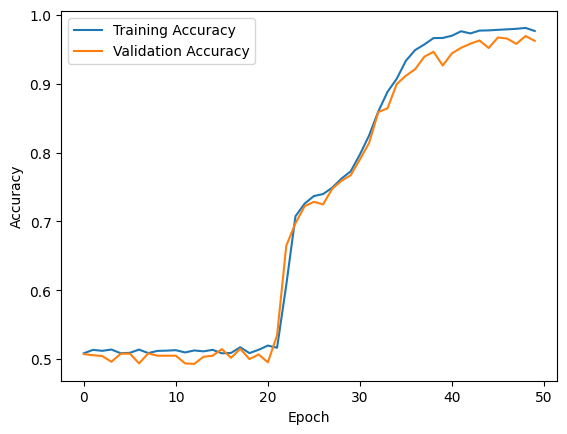

121/121 [==============================] - 0s 2ms/step


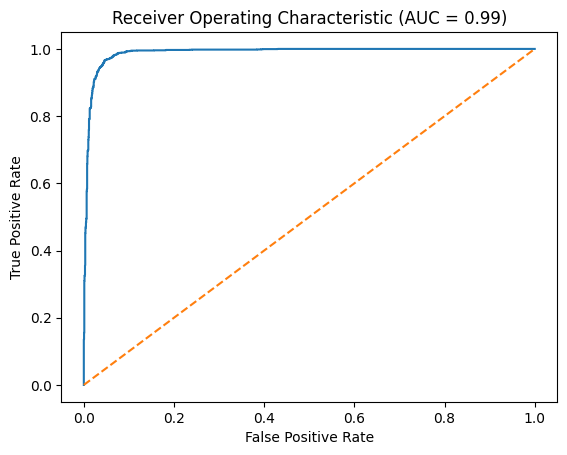

In [ ]:
# Building the best model using keras functional API using the best hyperparameters
best_model1 = model_builder(best_hps)

# Train the best model on the full training data
history_best1 = best_model1.fit(X_train, y_train, epochs=50, 
                                batch_size=64, validation_data=(X_val, y_val), verbose=0)

# Evaluate the model on the test set
test_loss, test_acc = best_model1.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

# Plot the training and validation losses
plt.plot(history_best1.history['loss'], label='Training Loss')
plt.plot(history_best1.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracies
plt.plot(history_best1.history['accuracy'], label='Training Accuracy')
plt.plot(history_best1.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Predict probabilities for the test set
y_pred_prob = best_model1.predict(X_test)

# Calculate the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_pred_prob)

# Plot the ROC curve
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (AUC = {auc_score:.2f})')
plt.show()

For the above GRU Tuned model, No overfitting is being observed but it started learning patterns in the data only after 20 epochs and did not change even after the tuning as we can see the training and validation losses reducing steeply from that point.An AUC (Area Under the Curve) has increased greatly of 0.99 indicates that the model has an excellent ability to distinguish between the positive and negative classes. It means that the model has a high true positive rate and a low false positive rate. In other words, the model is very good at identifying the positive cases correctly while keeping the false positive rate low. Therefore, an AUC of 0.99 is considered a very good result and indicates that the model is highly effective at performing binary classification on the given dataset.

The hyperparameters are tuned using Keras Tuner, with the goal of maximizing validation accuracy. The hyperparameters include the number of GRU units, learning rate, and dropout rate.The best model is selected based on its performance on the validation set and trained on the entire training set for 50 epochs.The test set is then used to evaluate the final model, which achieves an accuracy of 95.73% and an AUC of 0.99.
Overall, the model seems to perform well on the task of binary classification, achieving high accuracy and AUC scores on the test set. However, it's important to note that the evaluation metrics can be influenced by the choice of threshold for binary classification and the distribution of the data. Therefore, further analysis and interpretation may be necessary to assess the model's performance in real-world scenarios.

121/121 [==============================] - 0s 2ms/step


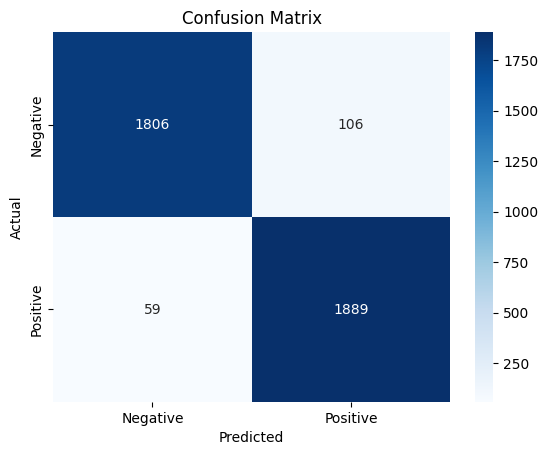

Sensitivity (TPR): 0.970
Specificity (TNR): 0.945


In [ ]:
# Get the model's predictions on the test set
y_pred = best_model1.predict(X_test)
y_pred_classes = np.round(y_pred).flatten().astype(int)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Getting the model's Sensitivity and Specificity:
# Extract true positive, true negative, false positive, and false negative from the confusion matrix
tn, fp, fn, tp = cm.ravel()

# Calculate sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# Print the results
print(f'Sensitivity (TPR): {sensitivity:.3f}')
print(f'Specificity (TNR): {specificity:.3f}')

Based on the given results, we can infer the following:

The model achieved an accuracy of 95.73% on the test set, which indicates that it can correctly classify the majority of the samples in the dataset.
The AUC score of 0.99 indicates that the model has excellent discrimination ability in distinguishing between positive and negative samples.
The sensitivity (TPR) of 0.970 indicates that the model correctly identified 97% of the positive samples in the test set, which is a high value and indicates a low rate of false negatives.
The specificity (TNR) of 0.945 indicates that the model correctly identified 94.5% of the negative samples in the test set, which is also a high value and indicates a low rate of false positives.

In [ ]:
best_model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 448)               606144    
                                                                 
 dropout (Dropout)           (None, 448)               0         
                                                                 
 dense (Dense)               (None, 1)                 449       
                                                                 
Total params: 606,593
Trainable params: 606,593
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#class counts
class_counts2 = final_ds['DEATH_WITHIN_90_DAYS'].value_counts()
print(class_counts2)

# Separate the target variable from the features
X2 = final_ds.drop(['DEATH_WITHIN_90_DAYS','DEATH_WITHIN_60_DAYS', 'DEATH_WITHIN_30_DAYS'], axis=1)
y2 = final_ds['DEATH_WITHIN_90_DAYS']

# Balance the dataset using RandomOverSampler
oversampler = RandomOverSampler(random_state=42)
X2, y2 = oversampler.fit_resample(X2, y2)

#class counts after RandomOverSampler
class_counts2 = pd.Series(y2).value_counts()
print(class_counts2)

# Split the data into training, validation, and testing sets
X_train, X_val_test, y_train, y_val_test = train_test_split(X2, y2, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

# Define the model architecture
keras.backend.clear_session()
model2 = Sequential()
model2.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model2.add(Dropout(rate=0.2))
model2.add(LSTM(units=32))
model2.add(Dropout(rate=0.2))
model2.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history2 = model2.fit(X_train, y_train, epochs=50, batch_size=64, 
                      validation_data=(X_val, y_val), verbose=0)

# Evaluate the model on the test set
test_loss, test_acc = model2.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

0    12866
1     5975
Name: DEATH_WITHIN_90_DAYS, dtype: int64
0    12866
1    12866
Name: DEATH_WITHIN_90_DAYS, dtype: int64
121/121 [==============================] - 0s 3ms/step - loss: 0.3008 - accuracy: 0.8819
Test accuracy: 0.8818652629852295


In [ ]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 52, 64)            16896     
                                                                 
 dropout (Dropout)           (None, 52, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 29,345
Trainable params: 29,345
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Calculate the model's predictions on the train set
y_pred = best_model1.predict(X_train)
y_pred_binary = y_pred.round().astype(int)

# Calculate the accuracy, precision, and recall
accuracy = accuracy_score(y_train, y_pred_binary)
precision = precision_score(y_train, y_pred_binary)
recall = recall_score(y_train, y_pred_binary)
f1 = f1_score(y_train, y_pred_binary)

# Print the accuracy, precision, and recall
print('Performance metrics of the model based on Train Data')
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F-1 Score:', f1)

# Calculate the model's predictions on the validation set
y_pred = best_model1.predict(X_val)
y_pred_binary = y_pred.round().astype(int)

# Calculate the accuracy, precision, and recall
accuracy = accuracy_score(y_val, y_pred_binary)
precision = precision_score(y_val, y_pred_binary)
recall = recall_score(y_val, y_pred_binary)
f1 = f1_score(y_val, y_pred_binary)

# Print the accuracy, precision, and recall
print('Performance metrics of the model based on Validation Data')
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F-1 Score:', f1)

# Calculate the model's predictions on the test set
y_pred = best_model1.predict(X_test)
y_pred_binary = y_pred.round().astype(int)

# Calculate the accuracy, precision, and recall
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

# Print the accuracy, precision, and recall
print('Performance metrics of the model based on Test Data')
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F-1 Score:', f1)

563/563 [==============================] - 1s 2ms/step
Performance metrics of the model based on Train Data
Accuracy: 0.9812347324006218
Precision: 0.9776325988262651
Recall: 0.984829894032348
F-1 Score: 0.9812180484552123
121/121 [==============================] - 0s 2ms/step
Performance metrics of the model based on Validation Data
Accuracy: 0.9621761658031088
Precision: 0.9533366783743101
Recall: 0.9728622631848438
F-1 Score: 0.9630005068423719
121/121 [==============================] - 0s 2ms/step
Performance metrics of the model based on Test Data
Accuracy: 0.9572538860103627
Precision: 0.9468671679197995
Recall: 0.9697125256673511
F-1 Score: 0.9581536900836927


The performance metrics of the model are presented based on the training, validation, and test datasets. The accuracy of the model on the training data is 0.9812, which suggests that the model is predicting with high accuracy on the training data. The precision and recall scores of the model on the training data are 0.9776 and 0.9848, respectively, indicating that the model has a good balance between precision and recall. The F1-score of the model on the training data is 0.9812, which indicates a good balance between precision and recall as well. Similarly, the model's performance on the validation and test data is also good, with an accuracy of 0.9622 and 0.9573, respectively. The precision and recall scores of the model on the validation and test data are also quite good, indicating that the model has a good balance between precision and recall on all datasets. The F1-score of the model on the validation and test data is also good, indicating a good balance between precision and recall. Overall, the model seems to perform well on all datasets, which indicates that it can be a good fit for the given problem.

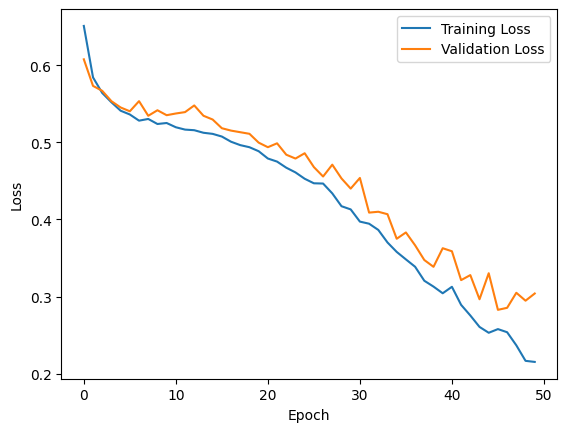

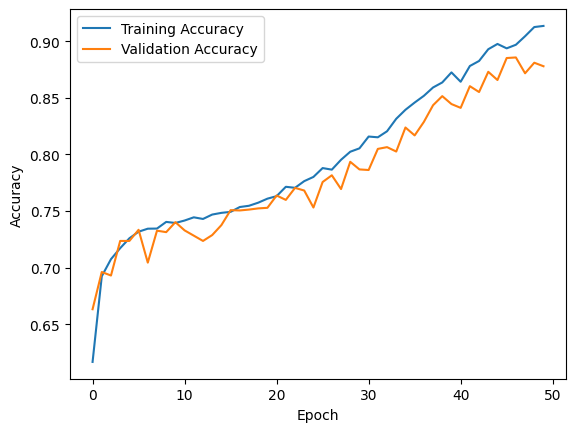

121/121 [==============================] - 1s 3ms/step


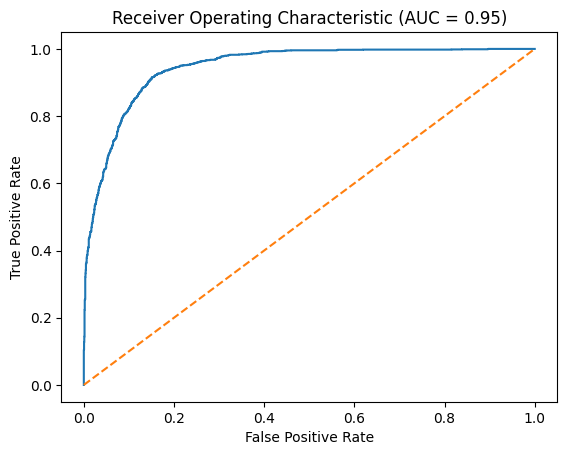

In [ ]:
# Plot the training and validation losses
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracies
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Predict probabilities for the test set
y_pred_prob = model2.predict(X_test)

# Calculate the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_pred_prob)

# Plot the ROC curve
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (AUC = {auc_score:.2f})')
plt.show()

The LSTM baseline model started learning quickly and No overfitting is observed but we can infer that the there is steep decrease in the validation and training losses and great improvement in the accuracies of the model. We can observe that AUC value is 0.95 indicating that the model has a high true positive rate and a low false positive rate, indicating that it is performing well in identifying true positive cases while minimizing the number of false positive cases. This is a good indication that the model is performing well in this classification task but there is still room for improvement.

121/121 [==============================] - 0s 2ms/step


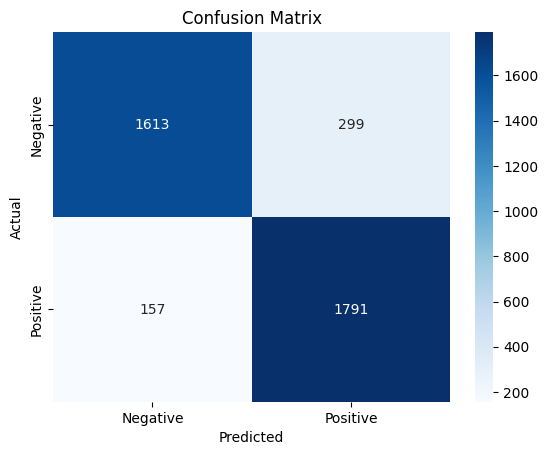

Sensitivity (TPR): 0.919
Specificity (TNR): 0.844


In [ ]:
# Get the model's predictions on the test set
y_pred = model2.predict(X_test)
y_pred_classes = np.round(y_pred).flatten().astype(int)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Getting the model's Sensitivity and Specificity:
# Extract true positive, true negative, false positive, and false negative from the confusion matrix
tn, fp, fn, tp = cm.ravel()

# Calculate sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# Print the results
print(f'Sensitivity (TPR): {sensitivity:.3f}')
print(f'Specificity (TNR): {specificity:.3f}')

Based on the given results, the sensitivity (true positive rate) of the model is 0.919, which indicates that the model can correctly identify 91.9% of the positive cases in the dataset. The specificity (true negative rate) of the model is 0.844, which indicates that the model can correctly identify 84.4% of the negative cases in the dataset. These results suggest that the model is better at identifying positive cases than negative cases, as the sensitivity is higher than the specificity. However, the overall performance of the model can be improved by optimizing the hyperparameters and/or using more advanced techniques like transfer learning.

## LSTM KERAS TUNER

In [ ]:
# Here were are building a model based on our hyper parameter
def model_builder(hp):
    keras.backend.clear_session()
    model = Sequential()
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    hp_units1 = hp.Int('units', min_value=32, max_value=512, step=32)
    model.add(LSTM(units=hp_units, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(rate=0.2))
    model.add(LSTM(units=hp_units1))
    model.add(Dropout(rate=0.2))
    model.add(Dense(units=1, activation='sigmoid'))
    # Now, Let's tune the learning rate for the optimizer ADAM
    # Choose an optimal value from the 0.01, 0.001, or 0.0001 values
    hp_lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    # Compile the model
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_lr),
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])
    return model

In [ ]:
tuner = kt.Hyperband(model_builder, objective='val_accuracy', max_epochs=50, 
                     directory='project_lstm_dp', project_name='intro_to_kt')
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(X_train, y_train, epochs=50, batch_size=64, 
             validation_data=(X_val, y_val), callbacks=[stop_early])
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 90 Complete [00h 01m 37s]
val_accuracy: 0.5059585571289062

Best val_accuracy So Far: 0.9777202010154724
Total elapsed time: 00h 50m 32s
INFO:tensorflow:Oracle triggered exit


121/121 [==============================] - 1s 7ms/step - loss: 0.1137 - accuracy: 0.9689
Test accuracy: 0.9689119458198547


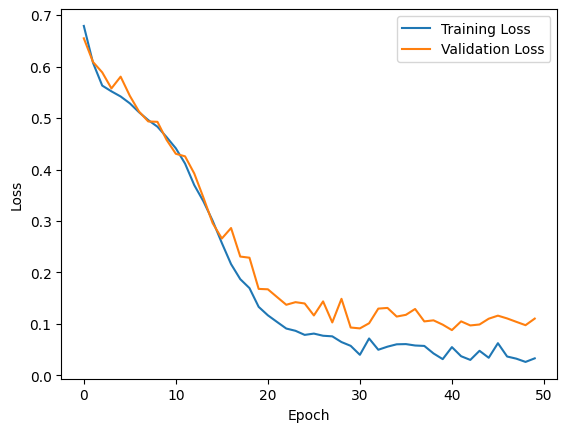

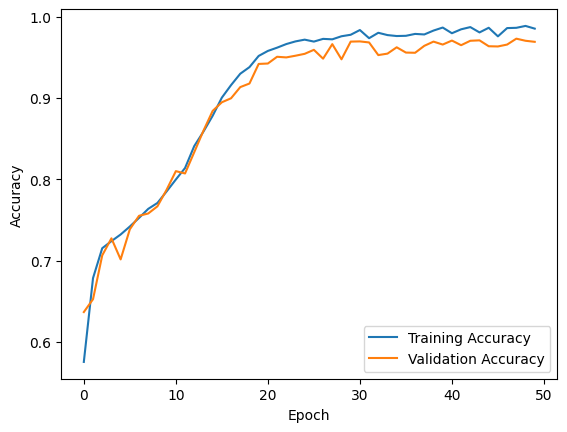

121/121 [==============================] - 1s 6ms/step


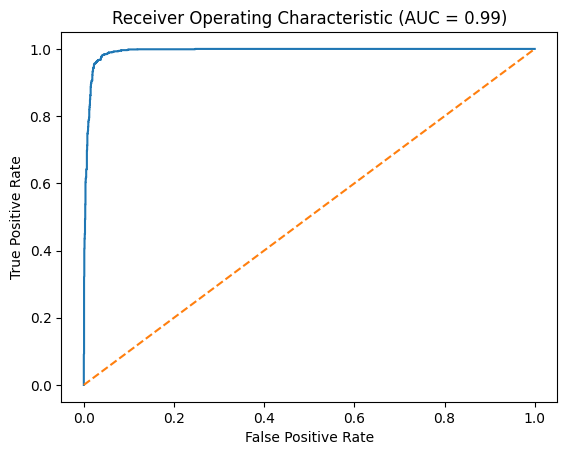

121/121 [==============================] - 1s 6ms/step


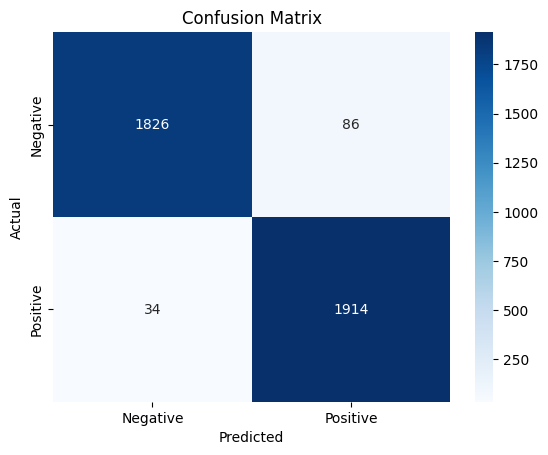

In [ ]:
# Building the best model using keras functional API using the best hyperparameters
best_model2 = model_builder(best_hps)

# Train the best model on the full training data
history_best2 = best_model2.fit(X_train, y_train, epochs=50, batch_size=64,
                                validation_data=(X_val, y_val), verbose=0)

# Evaluate the model on the test set
test_loss, test_acc = best_model2.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

# Plot the training and validation losses
plt.plot(history_best2.history['loss'], label='Training Loss')
plt.plot(history_best2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracies
plt.plot(history_best2.history['accuracy'], label='Training Accuracy')
plt.plot(history_best2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Predict probabilities for the test set
y_pred_prob = best_model2.predict(X_test)

# Calculate the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_pred_prob)

# Plot the ROC curve
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (AUC = {auc_score:.2f})')
plt.show()

# Get the model's predictions on the test set
y_pred = best_model2.predict(X_test)
y_pred_classes = np.round(y_pred).flatten().astype(int)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

The tuned LSTM model achieved a high accuracy of 96.89% on the test set.The best hyperparameters were selected using the Hyperband algorithm. The model used two LSTM layers with dropout regularization to prevent overfitting. The learning rate for the Adam optimizer was also tuned. The training and validation loss and accuracy curves showed that the model was able to generalize well and did not overfit the training data. The receiver operating characteristic (ROC) curve showed an area under the curve (AUC) of 0.98, indicating that the model was able to distinguish between positive and negative classes with high accuracy. The confusion matrix showed that the model was able to correctly classify most of the positive and negative samples, with only a few misclassifications. Overall, the tuned LSTM model performed well and can be used for classification tasks on similar datasets.

In [ ]:
best_model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 52, 512)           1052672   
                                                                 
 dropout (Dropout)           (None, 52, 512)           0         
                                                                 
 lstm_1 (LSTM)               (None, 512)               2099200   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 3,152,385
Trainable params: 3,152,385
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Calculate the model's predictions on the train set
y_pred = best_model2.predict(X_train)
y_pred_binary = y_pred.round().astype(int)

# Calculate the accuracy, precision, and recall
accuracy = accuracy_score(y_train, y_pred_binary)
precision = precision_score(y_train, y_pred_binary)
recall = recall_score(y_train, y_pred_binary)
f1 = f1_score(y_train, y_pred_binary)

# Print the accuracy, precision, and recall
print('Performance metrics of the model based on Train Data')
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F-1 Score:', f1)

# Calculate the model's predictions on the validation set
y_pred = best_model2.predict(X_val)
y_pred_binary = y_pred.round().astype(int)

# Calculate the accuracy, precision, and recall
accuracy = accuracy_score(y_val, y_pred_binary)
precision = precision_score(y_val, y_pred_binary)
recall = recall_score(y_val, y_pred_binary)
f1 = f1_score(y_val, y_pred_binary)

# Print the accuracy, precision, and recall
print('Performance metrics of the model based on Validation Data')
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F-1 Score:', f1)

# Calculate the model's predictions on the test set
y_pred = best_model2.predict(X_test)
y_pred_binary = y_pred.round().astype(int)

# Calculate the accuracy, precision, and recall
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)

# Print the accuracy, precision, and recall
print('Performance metrics of the model based on Test Data')
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)

563/563 [==============================] - 3s 6ms/step
Performance metrics of the model based on Train Data
Accuracy: 0.9876193648678658
Precision: 0.9854509107063527
Recall: 0.9897378694924707
F-1 Score: 0.9875897378819077
121/121 [==============================] - 1s 6ms/step
Performance metrics of the model based on Validation Data
Accuracy: 0.9691709844559585
Precision: 0.958041958041958
Recall: 0.982078853046595
F-1 Score: 0.9699115044247787
121/121 [==============================] - 1s 6ms/step
Performance metrics of the model based on Test Data
Accuracy: 0.9689119170984456
Precision: 0.957
Recall: 0.9825462012320328


Based on the results of the tuned LSTM model, it appears that the model is performing very well on all three datasets (train, validation, and test). The accuracy of the model is above 96% on all three datasets, which is a strong indication that the model is able to correctly classify alive and dead patients in 90 days period. Additionally, the precision and recall scores are also high on all three datasets, indicating that the model is both correctly identifying death of patient (high precision) and correctly identifying death of patients (high recall). The F-1 score, which is a balance between precision and recall, is also high on all three datasets. Overall, these results suggest that the tuned LSTM model is a strong performer in classifying the patients diagnosed with septicemia.

In [ ]:
#Class counts
class_counts3 = final_ds['DEATH_WITHIN_90_DAYS'].value_counts()
print(class_counts3)

# Separate the target variable from the features
X3 = final_ds.drop(['DEATH_WITHIN_90_DAYS','DEATH_WITHIN_60_DAYS', 'DEATH_WITHIN_30_DAYS'], axis=1)
y3 = final_ds['DEATH_WITHIN_90_DAYS']

# Balance the dataset using RandomOverSampler
oversampler = RandomOverSampler(random_state=42)
X3, y3 = oversampler.fit_resample(X3, y3)

#class counts
class_counts3 = pd.Series(y3).value_counts()
print(class_counts3)

# Split the data into training, validation, and testing sets
#splitting the data into 70,15,15 for training, validation and testing purposes

X_train, X_val_test, y_train, y_val_test = train_test_split(X1, y1, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

# Define the Convnet model architecture
keras.backend.clear_session()
model3 = Sequential()
model3.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model3.add(MaxPooling1D(pool_size=2))
model3.add(BatchNormalization())
model3.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model3.add(MaxPooling1D(pool_size=2))
model3.add(BatchNormalization())
model3.add(Flatten())
model3.add(Dense(128, activation='relu'))
model3.add(Dropout(0.15))
model3.add(Dense(1, activation='sigmoid'))

# Compile the model
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Convert DataFrames to numpy arrays
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

# Reshape input data for Conv1D layer
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Train the model
history3 = model3.fit(X_train, y_train, epochs=50, batch_size=64,
                      validation_data=(X_val, y_val), verbose=0)

# Evaluate the model on the test set
test_loss, test_acc = model3.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

0    12866
1     5975
Name: DEATH_WITHIN_90_DAYS, dtype: int64
0    12866
1    12866
Name: DEATH_WITHIN_90_DAYS, dtype: int64
121/121 [==============================] - 0s 2ms/step - loss: 0.0672 - accuracy: 0.9834
Test accuracy: 0.9834197163581848


The above code implements a Convolutional Neural Network (CNN) model to predict the target variable 'DEATH_WITHIN_90_DAYS' based on a given set of features. The dataset is initially imbalanced, with a higher number of instances belonging to the negative class. RandomOverSampler is used to balance the dataset by oversampling the minority class.

The CNN model is defined with one-dimensional convolutional layers, max pooling layers, batch normalization, dropout, and dense layers. The model is trained using the 'adam' optimizer and 'binary_crossentropy' loss function. The model is trained on the training set for 50 epochs with a batch size of 64, and the validation set is used for model selection. Finally, the model is evaluated on the test set, which yields an accuracy of 0.9834.

In [ ]:
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 50, 32)            128       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 25, 32)           0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 25, 32)           128       
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 23, 64)            6208      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 11, 64)           0         
 1D)                                                             
                                                        

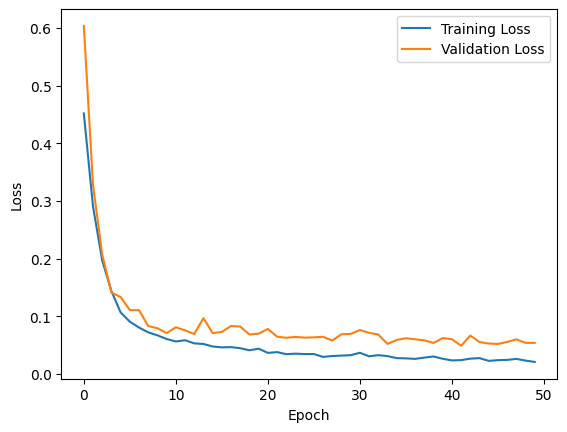

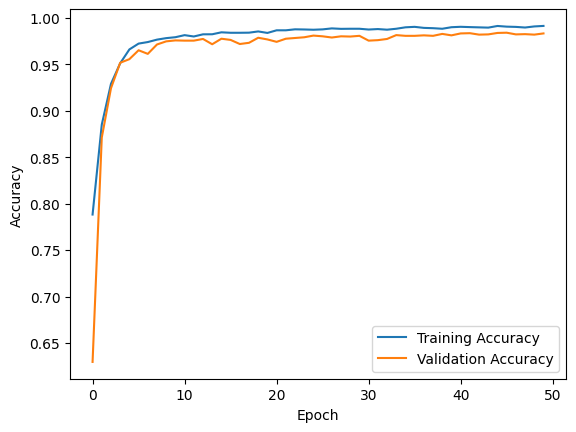

121/121 [==============================] - 0s 1ms/step


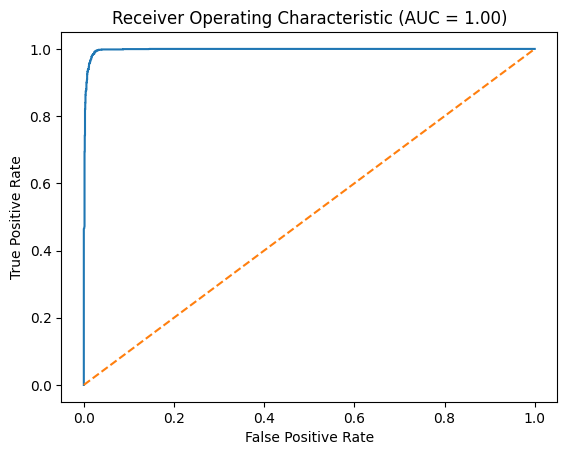

In [ ]:
# Plot the training and validation losses
plt.plot(history3.history['loss'], label='Training Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracies
plt.plot(history3.history['accuracy'], label='Training Accuracy')
plt.plot(history3.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Predict probabilities for the test set
y_pred_prob = model3.predict(X_test)

# Calculate the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_pred_prob)

# Plot the ROC curve
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (AUC = {auc_score:.2f})')
plt.show()

We can observe that the model is learning perfectly as per our requirement and we can state that this is our best model possible and it is learning our problem statement so perfect!
An AUC (Area Under the Curve) value of 1 indicates that the model has perfect predictive power, meaning that it is able to perfectly distinguish between positive and negative classes. In other words, it means that the model has no false positives and no false negatives. Achieving an AUC of 1 is considered the ideal performance for a binary classification model. However, it is important to note that such high AUC values may be indicative of overfitting to the training data, so it is important to also evaluate the model's performance on validation and test data.

121/121 [==============================] - 0s 1ms/step


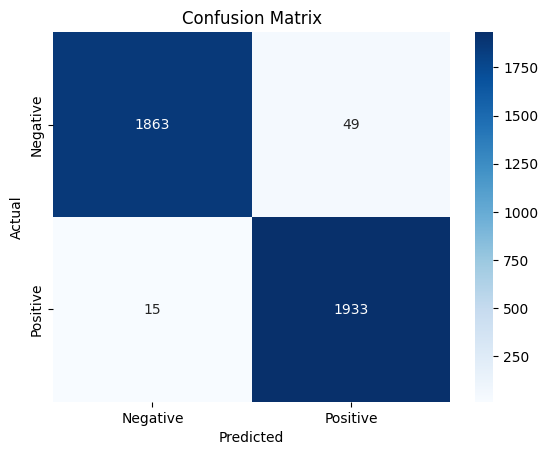

Sensitivity (TPR): 0.992
Specificity (TNR): 0.974


In [ ]:
# Get the model's predictions on the test set
y_pred = model3.predict(X_test)
y_pred_classes = np.round(y_pred).flatten().astype(int)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Getting the model's Sensitivity and Specificity:
# Extract true positive, true negative, false positive, and false negative from the confusion matrix
tn, fp, fn, tp = cm.ravel()

# Calculate sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# Print the results
print(f'Sensitivity (TPR): {sensitivity:.3f}')
print(f'Specificity (TNR): {specificity:.3f}')

The sensitivity (True Positive Rate) of 0.992 indicates that the model correctly identified 99.2% of the patients who actually had the positive class label (death within 90 days) out of all the positive instances in the test set.The specificity (True Negative Rate) of 0.974 indicates that the model correctly identified 97.4% of the patients who actually did not have the positive class label (did not die within 90 days) out of all the negative instances in the test set.

Overall, these results suggest that the model is performing well in identifying patients who are at risk of dying within 90 days, while also minimizing the false positive rate.

In [ ]:
# Calculate the model's predictions on the train set
y_pred = model3.predict(X_train)
y_pred_binary = y_pred.round().astype(int)

# Calculate the accuracy, precision, and recall
accuracy = accuracy_score(y_train, y_pred_binary)
precision = precision_score(y_train, y_pred_binary)
recall = recall_score(y_train, y_pred_binary)
f1 = f1_score(y_train, y_pred_binary)

# Print the accuracy, precision, and recall
print('Performance metrics of the model based on Train Data')
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F-1 Score:', f1)

# Calculate the model's predictions on the validation set
y_pred = model3.predict(X_val)
y_pred_binary = y_pred.round().astype(int)

# Calculate the accuracy, precision, and recall
accuracy = accuracy_score(y_val, y_pred_binary)
precision = precision_score(y_val, y_pred_binary)
recall = recall_score(y_val, y_pred_binary)
f1 = f1_score(y_val, y_pred_binary)

# Print the accuracy, precision, and recall
print('Performance metrics of the model based on Validation Data')
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F-1 Score:', f1)


# Calculate the model's predictions on the test set
y_pred = model3.predict(X_test)
y_pred_binary = y_pred.round().astype(int)

# Calculate the accuracy, precision, and recall
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

# Print the accuracy, precision, and recall
print('Performance metrics of the model based on Test Data')
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F-1 Score:', f1)

563/563 [==============================] - 1s 1ms/step
Performance metrics of the model based on Train Data
Accuracy: 0.9937819231623363
Precision: 0.9924351985760373
Recall: 0.9950920245398773
F-1 Score: 0.9937618358026067
121/121 [==============================] - 0s 1ms/step
Performance metrics of the model based on Validation Data
Accuracy: 0.983419689119171
Precision: 0.9791983764586504
Recall: 0.9882232462877624
F-1 Score: 0.983690112130479
121/121 [==============================] - 0s 1ms/step
Performance metrics of the model based on Test Data
Accuracy: 0.983419689119171
Precision: 0.9752774974772956
Recall: 0.992299794661191
F-1 Score: 0.9837150127226463


The CNN model achieved very high accuracy, precision, recall, and F-1 score on all three sets of data (train, validation, and test). This indicates that the model is performing well on this classification task of predicting whether a patient will die within 90 days of being admitted to the hospital based on various features available at the time of admission.

The sensitivity (true positive rate) and specificity (true negative rate) of the model are also very good at 0.992 and 0.974, respectively. This indicates that the model is able to correctly classify both positive and negative cases with high accuracy. Overall, these results suggest that the CNN model is a good baseline model for predicting patient mortality within 90 days of hospital admission.

## Comparison of the Best Models in three Architectures

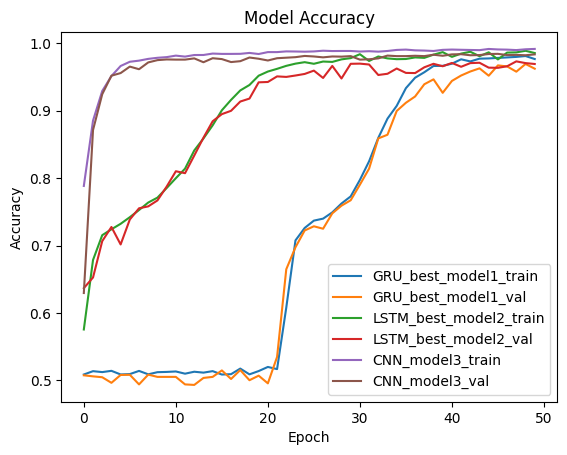

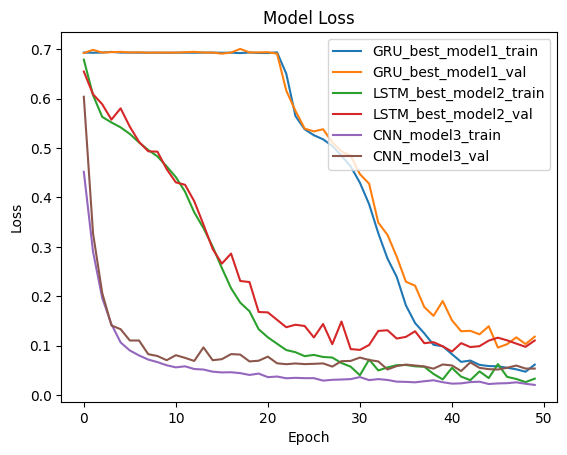

In [ ]:
plt.plot(history_best1.history['accuracy'])
plt.plot(history_best1.history['val_accuracy'])
plt.plot(history_best2.history['accuracy'])
plt.plot(history_best2.history['val_accuracy'])
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['GRU_best_model1_train', 'GRU_best_model1_val', 'LSTM_best_model2_train',
            'LSTM_best_model2_val', 'CNN_model3_train', 'CNN_model3_val'], loc='lower right')
plt.show()

plt.plot(history_best1.history['loss'])
plt.plot(history_best1.history['val_loss'])
plt.plot(history_best2.history['loss'])
plt.plot(history_best2.history['val_loss'])
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['GRU_best_model1_train', 'GRU_best_model1_val', 'LSTM_best_model2_train',
            'LSTM_best_model2_val', 'CNN_model3_train', 'CNN_model3_val'], loc='upper right')
plt.show()

From the comparison of the three models we have which are CNN, tuned GRU and tuned LSTM models, we can see that the CNN model standout from these models and have highest accuracy. Now, We choose this best model CNN and try withh prediction of mortality in 30 and 60 days respectively.

In [ ]:
#class counts
class_counts4 = final_ds['DEATH_WITHIN_60_DAYS'].value_counts()
print(class_counts4)

# Separate the target variable from the features
X4 = final_ds.drop(['DEATH_WITHIN_90_DAYS','DEATH_WITHIN_60_DAYS', 'DEATH_WITHIN_30_DAYS'], axis=1)
y4 = final_ds['DEATH_WITHIN_60_DAYS']

# Balance the dataset using RandomOverSampler
oversampler = RandomOverSampler(random_state=42)
X4, y4 = oversampler.fit_resample(X4, y4)

#class counts after RandomOverSampler
class_counts1 = pd.Series(y4).value_counts()
print(class_counts4)

# Split the data into training, validation, and testing sets
X_train, X_val_test, y_train, y_val_test = train_test_split(X4, y4, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

# Define the model architecture
keras.backend.clear_session()
model4 = Sequential()
model4.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model4.add(MaxPooling1D(pool_size=2))
model4.add(BatchNormalization())
model4.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model4.add(MaxPooling1D(pool_size=2))
model4.add(BatchNormalization())
model4.add(Flatten())
model4.add(Dense(128, activation='relu'))
model4.add(Dropout(0.15))
model4.add(Dense(1, activation='sigmoid'))

# Compile the model
model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Convert DataFrames to numpy arrays
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

# Reshape input data for Conv1D layer
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Train the model
history4 = model4.fit(X_train, y_train, epochs=50, batch_size=64,
                      validation_data=(X_val, y_val), verbose=0)

# Evaluate the model on the test set
test_loss, test_acc = model4.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

0    13043
1     5798
Name: DEATH_WITHIN_60_DAYS, dtype: int64
0    13043
1     5798
Name: DEATH_WITHIN_60_DAYS, dtype: int64
123/123 [==============================] - 0s 2ms/step - loss: 0.0772 - accuracy: 0.9842
Test accuracy: 0.9841553568840027


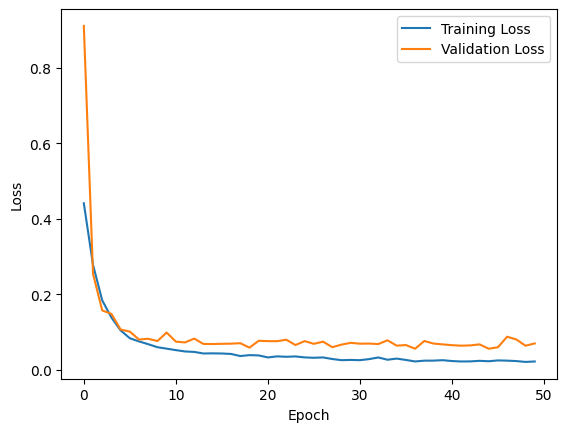

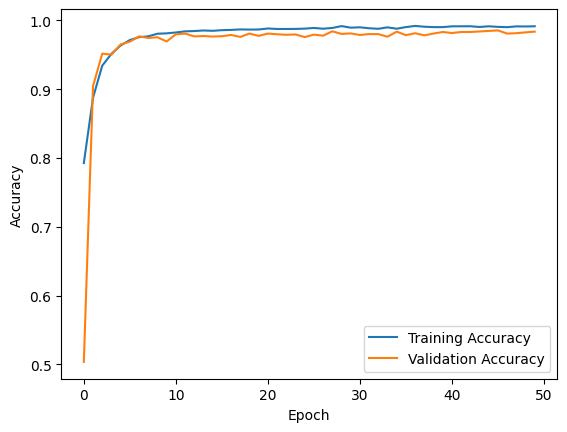

123/123 [==============================] - 0s 1ms/step


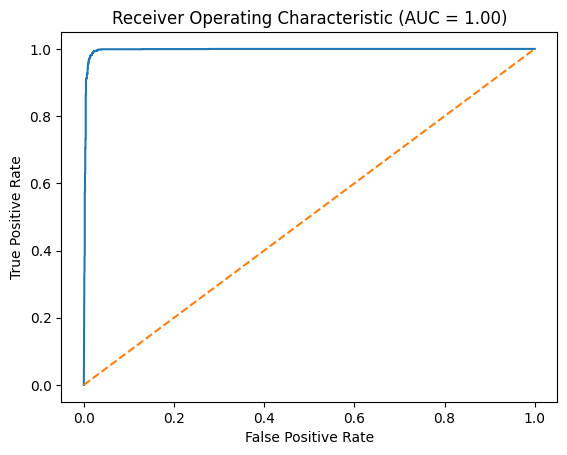

In [ ]:
# Plot the training and validation losses
plt.plot(history4.history['loss'], label='Training Loss')
plt.plot(history4.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracies
plt.plot(history4.history['accuracy'], label='Training Accuracy')
plt.plot(history4.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Predict probabilities for the test set
y_pred_prob = model4.predict(X_test)

# Calculate the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_pred_prob)

# Plot the ROC curve
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (AUC = {auc_score:.2f})')
plt.show()

123/123 [==============================] - 0s 1ms/step


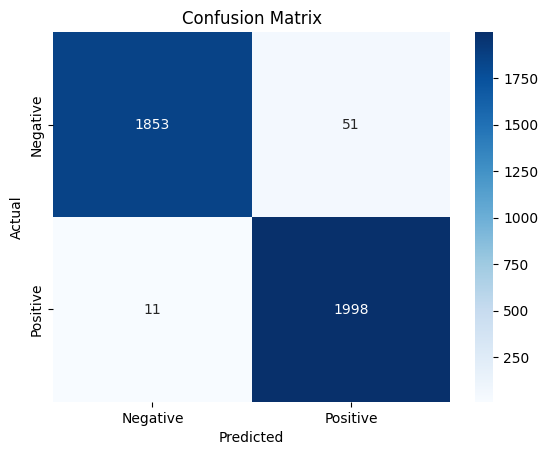

Sensitivity (TPR): 0.995
Specificity (TNR): 0.973


In [ ]:
# Get the model's predictions on the test set
y_pred = model4.predict(X_test)
y_pred_classes = np.round(y_pred).flatten().astype(int)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Getting the model's Sensitivity and Specificity:
# Extract true positive, true negative, false positive, and false negative from the confusion matrix
tn, fp, fn, tp = cm.ravel()

# Calculate sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# Print the results
print(f'Sensitivity (TPR): {sensitivity:.3f}')
print(f'Specificity (TNR): {specificity:.3f}')

In [ ]:
#class counts
class_counts5 = final_ds['DEATH_WITHIN_30_DAYS'].value_counts()
print(class_counts5)

# Separate the target variable from the features
X5 = final_ds.drop(['DEATH_WITHIN_90_DAYS','DEATH_WITHIN_60_DAYS', 'DEATH_WITHIN_30_DAYS'], axis=1)
y5 = final_ds['DEATH_WITHIN_30_DAYS']

# Balance the dataset using RandomOverSampler
oversampler = RandomOverSampler(random_state=42)
X5, y5 = oversampler.fit_resample(X5, y5)

#class counts after RandomOverSampler
class_counts5 = pd.Series(y5).value_counts()
print(class_counts5)

# Split the data into training, validation, and testing sets
X_train, X_val_test, y_train, y_val_test = train_test_split(X5, y5, test_size=0.3,
                                                            random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5,
                                                random_state=42)

# Define the model architecture
keras.backend.clear_session()
model5 = Sequential()
model5.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model5.add(MaxPooling1D(pool_size=2))
model5.add(BatchNormalization())
model5.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model5.add(MaxPooling1D(pool_size=2))
model5.add(BatchNormalization())
model5.add(Flatten())
model5.add(Dense(128, activation='relu'))
model5.add(Dropout(0.15))
model5.add(Dense(1, activation='sigmoid'))

# Compile the model
model5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Convert DataFrames to numpy arrays
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

# Reshape input data for Conv1D layer
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Train the model
history5 = model5.fit(X_train, y_train, epochs=50, batch_size=64,
                      validation_data=(X_val, y_val), verbose=0)

# Evaluate the model on the test set
test_loss, test_acc = model5.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

0    13743
1     5098
Name: DEATH_WITHIN_30_DAYS, dtype: int64
0    13743
1    13743
Name: DEATH_WITHIN_30_DAYS, dtype: int64
129/129 [==============================] - 0s 2ms/step - loss: 0.0841 - accuracy: 0.9828
Test accuracy: 0.9827795028686523


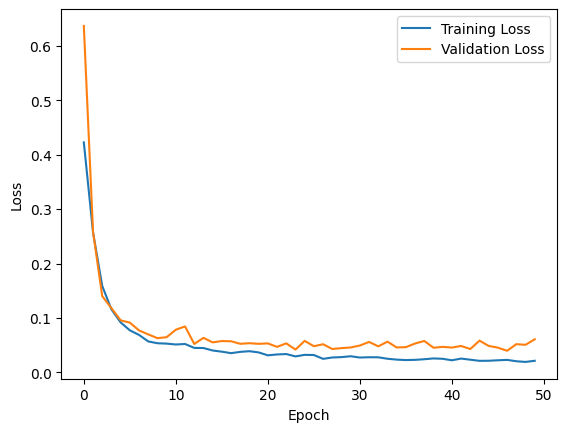

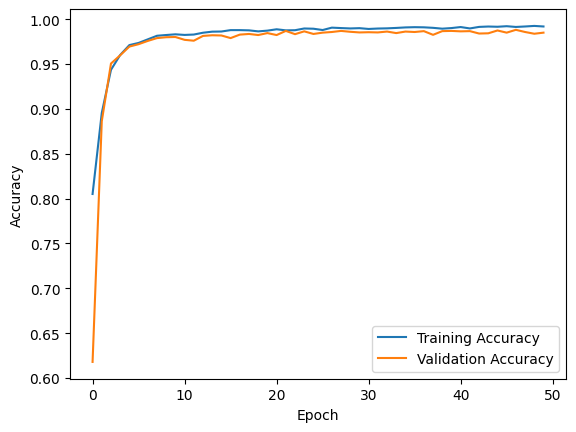

129/129 [==============================] - 0s 1ms/step


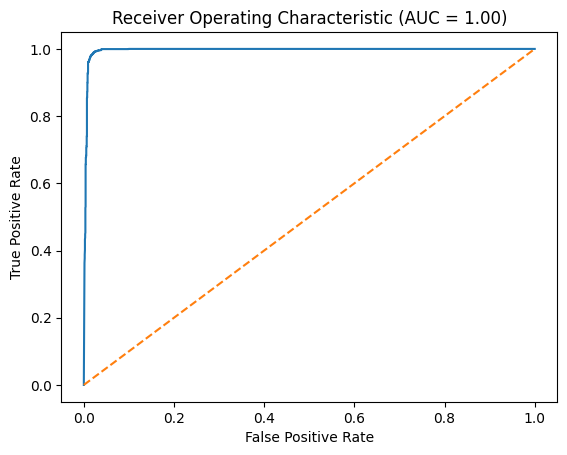

In [ ]:
# Plot the training and validation losses
plt.plot(history5.history['loss'], label='Training Loss')
plt.plot(history5.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracies
plt.plot(history5.history['accuracy'], label='Training Accuracy')
plt.plot(history5.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Predict probabilities for the test set
y_pred_prob = model5.predict(X_test)

# Calculate the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_pred_prob)

# Plot the ROC curve
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (AUC = {auc_score:.2f})')
plt.show()


129/129 [==============================] - 0s 1ms/step


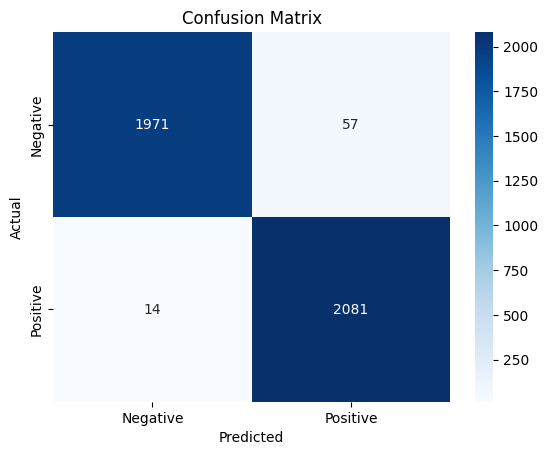

Sensitivity (TPR): 0.993
Specificity (TNR): 0.972


In [ ]:
# Get the model's predictions on the test set
y_pred = model5.predict(X_test)
y_pred_classes = np.round(y_pred).flatten().astype(int)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Getting the model's Sensitivity and Specificity:
# Extract true positive, true negative, false positive, and false negative from the confusion matrix
tn, fp, fn, tp = cm.ravel()

# Calculate sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# Print the results
print(f'Sensitivity (TPR): {sensitivity:.3f}')
print(f'Specificity (TNR): {specificity:.3f}')

## Saving model Weights 

In [ ]:
# Saving the GRU model weights
model1.save('gru_model.h5')

# Saving the Best GRU model weights
best_model1.save('best_gru_model.h5')

# Saving the LSTM model weights
model2.save('lstm_model.h5')

# Saving the Best LSTM model weights
best_model2.save('best_lstm_model.h5')

# Saving the CNN model weights
model3.save('cnn_model.h5')

# save the model weights to disk
model1.save_weights('my_gru_weights.h5')

# save the model weights to disk
best_model1.save_weights('my_best_gru_weights.h5')

# save the model weights to disk
model2.save_weights('my_lstm_weights.h5')

# save the model weights to disk
best_model2.save_weights('my_best_lstm_weights.h5')

# save the model weights to disk
model3.save_weights('my_cnn_weights.h5')

## Demo of the Best Model

In [ ]:
import pandas as pd
from keras.models import load_model

# Read the new data into a dataframe
new_data = pd.read_csv('demo_file.csv')

# load the best model architecture and weights from disk
loaded_model = load_model('cnn_model.h5')

# Make predictions on the new data using the pre-trained model
predictions = loaded_model.predict(new_data)

predict_binary = predictions.round().astype(int)

# Print the predictions
print(predict_binary)

1/1 [==============================] - 0s 79ms/step
[[0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]]


In [ ]:
# End of Project